In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 결측치 시각화를 위한 라이브러리
import missingno

### ✅ RFM 분석: Recency 컬럼 선정 기준

Recency는 고객이 **얼마나 최근에 거래했는지**를 의미합니다. 하지만 여러 날짜 관련 컬럼이 있는 경우, 단순히 하나만 고르는 것이 아닌 **"의미 있는 대표 컬럼을 선정"**하는 것이 중요합니다.

---

#### 🔍 R(Recency) 컬럼 선정 기준

| 기준 | 설명 | 적용 예시 |
|------|------|-----------|
| **1️⃣ 비즈니스 맥락** | 어떤 거래가 고객 충성도에 더 의미 있는가? | 예: "체크카드"보다 "신용카드 할부" 거래가 중요하다면 `최종이용일자_할부` 우선 |
| **2️⃣ 데이터 sparsity** | 결측치 적고 대부분의 고객에게 값이 있는가? | `최종이용일자_기본`이 대부분 채워져 있으면 우선 |
| **3️⃣ 분석 목적 정렬** | 예측/클러스터링 대상과 밀접한 컬럼인가? | 예: 향후 마케팅 대상이 신용카드 고객이라면 `이용후경과월_신용` 선택 |
| **4️⃣ 팀 분석 결과 활용** | 모델에서 중요하게 작용한 컬럼이 있다면 우선 선택 | 예: `이용후경과월_할부`의 SHAP값이 높다면 우선 채택 |

---

#### ✅ 추천 방법

1. `최종이용일자_기본` 또는 `이용후경과월_신용`과 같이 **가장 범용적이고 공통적인 컬럼**부터 확인
2. **각 컬럼의 결측치 비율, 고객 분포** 확인 (`.isna().mean()`, `value_counts()` 등 활용)
3. **도메인 지식 + 모델 해석 결과**를 바탕으로 최종 선정

---

#### 💡 실무에서 자주 쓰는 Recency 컬럼 예시

- 날짜형: `최종이용일자_기본`, `최종이용일자_신용`
- 경과형: `이용후경과월_신용`, `이용후경과월_CA`
- 개월수 누적형: `이용개월수_신용_R12M`, `이용개월수_할부_R6M`

---

> 🔎 **Recency는 단일 날짜가 아닌, 비즈니스/데이터 구조/모델링 결과에 따라 가장 의미 있는 "최근 사용"을 대표할 수 있는 컬럼을 선정하는 것**이 중요합니다.


## R 관련된 컬럼 선정

## 📊 RFM 분석용 컬럼 평가표

| 구분 | 후보 컬럼명 | 설명 | 결측치/0값 비율 | 변별력(분산) | 적절성 평가 |
|------|--------------|------|------------------|----------------|--------------|
| **R (Recency)** | `이용후경과월_신판` | 신판 기준 이용 후 경과 개월 수 | 낮음 | 보통 | ✅ |
|  | `이용후경과월_일시불` | 일시불 기준 이용 후 경과 개월 수 | 낮음 | 보통 | ✅ |
|  | `이용후경과월_할부` | 할부 기준 이용 후 경과 개월 수 | 보통 | 높음 | ✅ |
| **F (Frequency)** | `이용건수합계_R12M` | 지난 12개월간 총 이용 건수 | 매우 낮음 | 높음 | ✅✅ |
|  | `할부건수_R12M` | 지난 12개월간 할부 이용 건수 | 약간 있음 | 중간 | ⚠️ |
| **M (Monetary)** | `결제금액합계_R12M` | 지난 12개월간 총 결제 금액 | 낮음 | 높음 | ✅✅ |
|  | `일시불금액합계_R12M` | 일시불만 기준한 금액 | 보통 | 보통 | ⚠️ |
|  | `할부금액합계_R12M` | 할부 기준 금액 | 약간 있음 | 높음 | ✅ |

> ⚠️: 보조 지표로는 가능하지만 단독으로 사용 시 한계  
> ✅: 사용 가능  
> ✅✅: 가장 대표 컬럼으로 추천


### 진행하면서, 수정해가기

In [6]:
import pandas as pd

# 파일 경로 설정
file_path = 'data/train/3.승인매출정보/201812_train_승인매출정보.parquet'

# parquet 파일 불러오기
df3_12mon = pd.read_parquet(file_path)

# 데이터 확인
df3_12mon

,기준년월,ID,최종이용일자_기본,최종이용일자_신판,최종이용일자_CA,최종이용일자_카드론,최종이용일자_체크,최종이용일자_일시불,최종이용일자_할부,이용건수_신용_B0M,...,승인거절건수_한도초과_B0M,승인거절건수_BL_B0M,승인거절건수_입력오류_B0M,승인거절건수_기타_B0M,승인거절건수_R3M,승인거절건수_한도초과_R3M,승인거절건수_BL_R3M,승인거절건수_입력오류_R3M,승인거절건수_기타_R3M,이용금액대
0,201812,TRAIN_000000,20181224,20181224,20181221,10101,20180203,20181224,20180713,7,...,0,0,0,0,0,0,0,0,0,01.100만원+
1,201812,TRAIN_000001,20181214,20181214,20170728,20170327,10101,20181214,20171231,9,...,0,0,0,0,0,0,0,0,0,03.30만원+
2,201812,TRAIN_000002,20181228,20181228,20181216,20151119,20141230,20181228,20181115,20,...,0,0,0,0,0,0,0,0,0,01.100만원+
3,201812,TRAIN_000003,20181221,20181212,20181221,10101,20141111,20181203,20181212,12,...,0,0,0,0,0,0,0,0,0,01.100만원+
4,201812,TRAIN_000004,20180905,20180905,10101,10101,20181210,20180905,10101,0,...,0,0,0,0,0,0,0,0,0,05.10만원-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,201812,TRAIN_399995,20181220,20181220,10101,10101,20181212,20181220,20160501,2,...,0,0,0,0,0,0,0,0,0,09.미사용
399996,201812,TRAIN_399996,20181202,20181202,10101,20170112,10101,20181202,20180112,10,...,0,0,0,0,0,0,0,0,0,01.100만원+
399997,201812,TRAIN_399997,20181230,20181230,10101,10101,20131124,20181230,20180919,10,...,0,0,0,0,0,0,0,0,0,02.50만원+
399998,201812,TRAIN_399998,20161224,20161224,10101,10101,10101,20161224,20150122,-2,...,0,0,0,0,0,0,0,0,0,09.미사용


#### ✅ 추천 순서 (12월 승인매출 데이터 기준)
- R/F/M 컬럼 분포 확인

1. 결측치 여부

2. 0값 비율

3. 값 분포 (describe, histogram 등)

>>> 이상이 없으면 RFM 분석 진행

>>>이상이 있으면 로그 변환, 이진화, 결측처리 후 진행

## R 관련된 컬럼 목록
1. 결측치, 0값 비율, 값 분포 확인
2. 수정 사항(7/8)
- 이용후경과월신용, 이용후경과월체크, 이용후경과월카드론 중에서 가장 최소 인 것을 골라보자
- 이때 이용후경과월신용(일시불/현금/할부 서비스 포함)

In [9]:
df3_12mon[['이용후경과월_신용', '이용후경과월_체크', '이용후경과월_카드론']]

,이용후경과월_신용,이용후경과월_체크,이용후경과월_카드론
0,0,10,12
1,0,12,12
2,0,12,12
3,0,12,12
4,3,0,12
...,...,...,...
399995,8,0,12
399996,0,12,12
399997,1,12,12
399998,12,12,12


In [10]:
# 결측치 여부를 확인할 수 있는 코드
# 결측치 개수 확인
r_cols = ['이용후경과월_신용', '이용후경과월_체크', '이용후경과월_카드론']
df3_12mon[r_cols].isnull().sum()

이용후경과월_신용     0
이용후경과월_체크     0
이용후경과월_카드론    0
dtype: int64

In [11]:
# 0값 비율 계산 (%)
(df3_12mon[r_cols] == 0).sum() / len(df3_12mon) * 100

이용후경과월_신용     49.14450
이용후경과월_체크     13.30725
이용후경과월_카드론     0.00025
dtype: float64

In [12]:
# 최소값을 확인하여 최소값이 가장 작은 컬럼을 R로 지정한다.

r_cols = ['이용후경과월_신용', '이용후경과월_체크', '이용후경과월_카드론']

# 각 컬럼별 최소값 출력
for col in r_cols:
    min_val = df3_12mon[col].min()
    print(f"🔍 {col}의 최소값: {min_val}")

🔍 이용후경과월_신용의 최소값: 0
🔍 이용후경과월_체크의 최소값: 0
🔍 이용후경과월_카드론의 최소값: 0


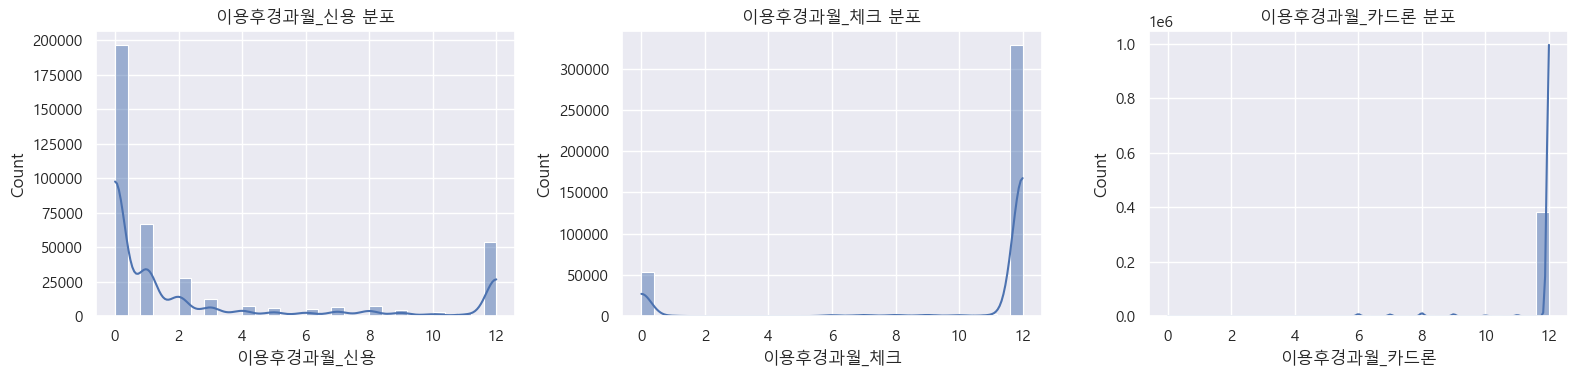

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 4))
for i, col in enumerate(r_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data=df3_12mon, x=col, bins=30, kde=True)
    plt.title(f'{col} 분포')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

## 📌 Recency (R) 후보 컬럼 분석

분석 대상:  
- `이용후경과월_신용`  
- `이용후경과월_체크`  
- `이용후경과월_카드론`

---

### ✅ 결측치 여부
- **전부 결측치 없음**

---

### ✅ 0값 비율 (%)

| 컬럼명             | 0값 비율 (%) |
|------------------|-------------|
| 이용후경과월_신용   | 48%      |
| 이용후경과월_체크 | 12%      |
| 이용후경과월_카드론   |  0%      |

---

### ✅ 해석 및 활용 가능성

### R(Recency): `이용후경과월_신용`  
  → 최소값 0 / 0값 비율 49%로, 가장 최근 이용을 잘 반영하는 지표로 판단.

## 이 부분 수정(7/8)
- R의 경우에는 0이 많고, 분포가 비대칭적이고, 많아서 Pd.cut()이 작동되지 않는다.
- 누적 비율을 구해서 나눠주자

In [16]:
import pandas as pd

# 예시: Recency 기준으로 값 분포 확인
r_counts = df3_12mon['이용후경과월_신용'].value_counts().sort_index()
r_ratio = (r_counts / len(df3_12mon) * 100).round(2)
r_cumsum = r_ratio.cumsum().round(2)

# 결과 테이블 생성
r_cdf_table = pd.DataFrame({
    'Recency': r_counts.index,
    '비율 (%)': r_ratio.values,
    '누적 (%)': r_cumsum.values
})

display(r_cdf_table)

,Recency,비율 (%),누적 (%)
0,0,49.14,49.14
1,1,16.71,65.85
2,2,6.95,72.80
3,3,3.14,75.94
4,4,1.94,77.88
5,5,1.41,79.29
6,6,1.24,80.53
7,7,1.61,82.14
8,8,1.89,84.03
9,9,1.21,85.24


## F 관련된 컬럼 목록
1. 결측치, 0값 비율, 값의 분포 확인

In [18]:
df3_12mon[['이용건수_신용_B0M', '이용건수_신판_B0M', '이용건수_일시불_B0M', '이용건수_할부_B0M', '이용건수_할부_유이자_B0M', '이용건수_할부_무이자_B0M',
           '이용건수_부분무이자_B0M', '이용건수_CA_B0M', '이용건수_체크_B0M', '이용건수_카드론_B0M']]

,이용건수_신용_B0M,이용건수_신판_B0M,이용건수_일시불_B0M,이용건수_할부_B0M,이용건수_할부_유이자_B0M,이용건수_할부_무이자_B0M,이용건수_부분무이자_B0M,이용건수_CA_B0M,이용건수_체크_B0M,이용건수_카드론_B0M
0,7,5,5,0,0,0,0,2,0,0
1,9,9,9,0,0,0,0,0,0,0
2,20,18,18,0,0,0,0,2,0,0
3,12,10,9,1,1,0,0,2,0,0
4,0,0,0,0,0,0,0,0,10,0
...,...,...,...,...,...,...,...,...,...,...
399995,2,2,2,0,0,0,0,0,14,0
399996,10,10,10,0,0,0,0,0,0,0
399997,10,10,10,0,0,0,0,0,0,0
399998,-2,-2,-2,0,0,0,0,0,0,0


### 이용건수합계 컬럼 생성
- 이용건수를 특징 하는 아래의 컬럼 목록들을 합해서 하나의 새로운 변수을 만든다.
- 이용건수_신용_B0M
- 신용 네 이녀석... 모든 걸을 떠안고 있었구나.. 너로 정했다.

In [20]:
# 이용건수 관련 컬럼 리스트
usage_cols = [
    '이용건수_신용_B0M'
]

# 합계 컬럼 생성
df3_12mon['이용건수합계_B0M'] = df3_12mon[usage_cols].sum(axis=1)

✅ '이용건수합계_B0M' 결측치 개수: 0
✅ '이용건수합계_B0M' 0값 비율: 8.52%


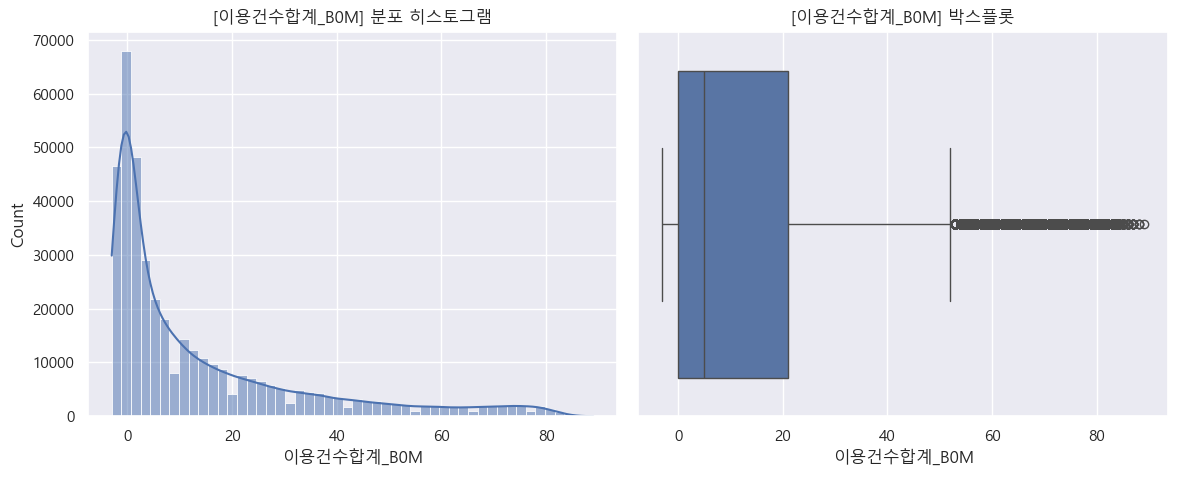

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# 확인할 컬럼
target_col = '이용건수합계_B0M'

# 1. 결측치 여부 확인
missing = df3_12mon[target_col].isna().sum()
print(f"✅ '{target_col}' 결측치 개수:", missing)

# 2. 0 값 비율 확인
zero_ratio = (df3_12mon[target_col] == 0).mean() * 100
print(f"✅ '{target_col}' 0값 비율: {zero_ratio:.2f}%")

# 3. 값 분포 시각화 (히스토그램 + 박스플롯)
plt.figure(figsize=(12, 5))

# 히스토그램
plt.subplot(1, 2, 1)
sns.histplot(df3_12mon[target_col], bins=50, kde=True)
plt.title(f"[{target_col}] 분포 히스토그램")

# 박스플롯
plt.subplot(1, 2, 2)
sns.boxplot(x=df3_12mon[target_col])
plt.title(f"[{target_col}] 박스플롯")

plt.tight_layout()
plt.show()

### 문제점
1. 개별 이용건수 컬럼에 마이너스 값이 존재한다.
>> 이용건수에 마이너스 값은 적절하지 않다. 적절한 처리가 필요하다.
>>
2. 개별적 컬럼을 그냥 합산해서 사용해도 괜찮은 것인지?
>>  의미상 동일한 단위를 합산한 것이므로 OK.
>> 즉, 신용/할부/CA/체크 구분 없이 “총 사용 빈도”가 궁금하다면 합산은 적절함.
>>
>> 최종: 음수값 보정한다면 F 척도로 사용할 수 있을 듯

## ✅ F (Frequency) 지표 선정 평가

### 🔍 후보 컬럼: `이용건수합계_B0M`

| 평가 항목             | 결과 및 해석 |
|----------------------|--------------|
| 결측치 여부           | 없음 ✅       |
| 0값 비율              | 약 8.5%로 낮은 편 ✅ |
| 값의 분포             | 오른쪽으로 긴 꼬리(왜도 있음), 이상치 존재하지만 대다수는 0~50 사이 ✅ |
| 음수값 존재 여부       | 있음 → 보정 필요 ⚠️ |
| 지표로서의 의미        | 모든 이용건수를 합산한 총 빈도로 의미 충분 ✅ |

### ✅ 결론
- **음수값을 보정한다면** `이용건수합계_B0M` 컬럼은 F 지표로 활용 가능

In [24]:
# 음수 값 보정
# 마이너스 값 확인
(df3_12mon['이용건수합계_B0M'] < 0).sum()

80414

In [25]:
# 어떤 것에서 음수가 나왔는지, 확인
# 합산에 사용된 개별 컬럼 중 어떤 것이 음수인지 확인
cols = ['이용건수_신용_B0M']

(df3_12mon[cols] < 0).sum()

이용건수_신용_B0M    80414
dtype: int64

In [26]:
# 음수를 제거하고 합산하는 방식
# 음수값은 0으로 대체한 후, 합산
cols = [
    '이용건수_신용_B0M'
]

# 음수값 0으로 처리하고 합산
df3_12mon['이용건수합계_B0M_정제'] = df3_12mon[cols].applymap(lambda x: x if x > 0 else 0).sum(axis=1)

✅ '이용건수합계_B0M_정제' 결측치 개수: 0
✅ '이용건수합계_B0M_정제' 0값 비율: 28.63%


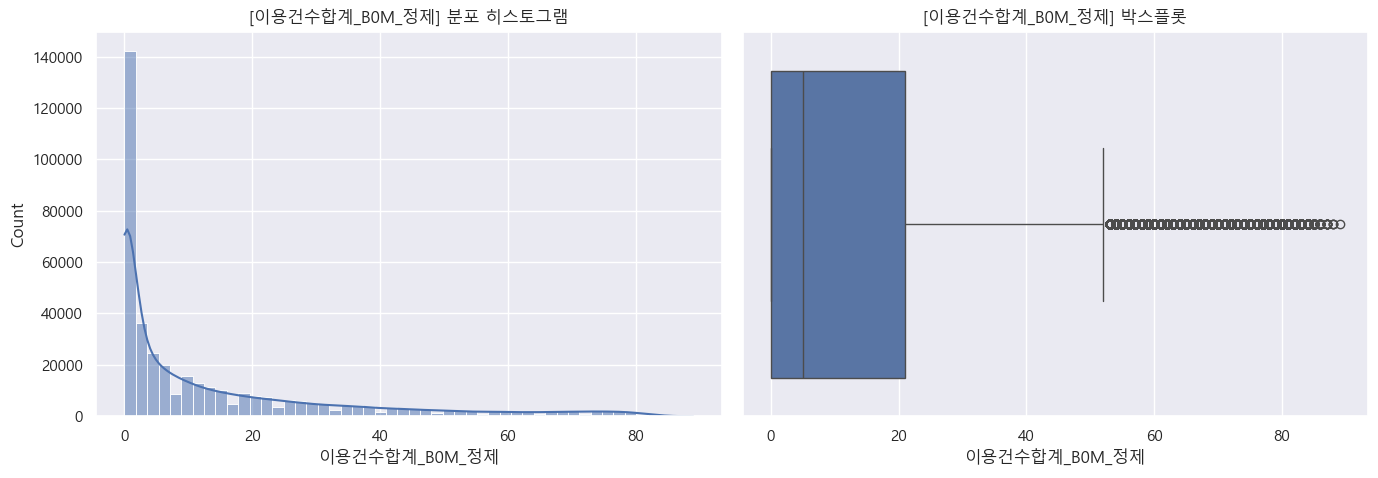

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

col = '이용건수합계_B0M_정제'

# 1. 결측치 및 0값 비율 출력
missing_count = df3_12mon[col].isna().sum()
zero_ratio = (df3_12mon[col] == 0).mean() * 100

print(f"✅ '{col}' 결측치 개수: {missing_count}")
print(f"✅ '{col}' 0값 비율: {zero_ratio:.2f}%")

# 2. 히스토그램 + KDE
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(df3_12mon[col], kde=True, bins=50)
plt.title(f"[{col}] 분포 히스토그램")
plt.xlabel(col)

# 3. 박스플롯
plt.subplot(1, 2, 2)
sns.boxplot(x=df3_12mon[col])
plt.title(f"[{col}] 박스플롯")
plt.tight_layout()
plt.show()

## M과 관련된 컬럼 추출
- 현재, 합계라는 컬럼이 따로 없고, 개별적으로 명시된 컬럼들만 존재하므로
- 새로운 컬럼을 만들어줘야 한다.

### 합계 컬럼 생성 시 사용되는 컬럼 목록
- 기간은 어떻게 선정했을까?
- 앞서서 F 관련 컬럼을 추출할 때도 당월 기준으로 추출했기 때문에, 동일하게 맞추자.
-  예외적으로, 거래 빈도는 높지 않지만 한 번에 큰 금액을 쓰는 경우, R12M 참고 가능
>>>> 우선은 기본은 B0M으로 맞춰서 가자

## 💰 M (Monetary) 값 산정 기준 및 컬럼 선정

### 📌 배경
- 고객의 소비 총액을 나타내는 **M 값(Monetary)** 은 최근 한 달(B0M)의 결제 금액 데이터를 기반으로 계산
- 주어진 컬럼은 다음과 같이 구성됨

| 결제 유형 | 컬럼명 |
|-----------|--------|
| 일시불    | 이용금액_일시불_B0M |
| 할부      | 이용금액_할부_B0M |
| CA        | 이용금액_CA_B0M |
| 체크카드  | 이용금액_체크_B0M |
| 카드론    | 이용금액_카드론_B0M |
| 기타 (세부) | 이용금액_할부_유이자_B0M 등 |

### ✅ 판단 기준
- `이용금액_할부_B0M` 컬럼은 이미 유이자/무이자 등을 포함한 총합일 가능성이 높음
- 따라서 세부 컬럼 (`이용금액_할부_유이자_B0M`, `무이자_B0M` 등)을 추가로 합산하면 **중복**될 수 있음

### ✅ 최종 선정 컬럼 (단순 합산 전략)
- `이용금액_일시불_B0M`
- `이용금액_할부_B0M`
- `이용금액_CA_B0M`
- `이용금액_체크_B0M`
- `이용금액_카드론_B0M`

### 🧮 최종 합산 컬럼명: `결제금액합계_B0M`


In [31]:
# 이용금액 총합 (M - Monetary 지표)
df3_12mon['결제금액합계_B0M'] = (
    df3_12mon['이용금액_일시불_B0M'] +
    df3_12mon['이용금액_할부_B0M'] +
    df3_12mon['이용금액_CA_B0M'] +
    df3_12mon['이용금액_체크_B0M'] +
    df3_12mon['이용금액_카드론_B0M']
)

✅ '결제금액합계_B0M' 결측치 개수: 0
✅ '결제금액합계_B0M' 0값 비율: 21.89%


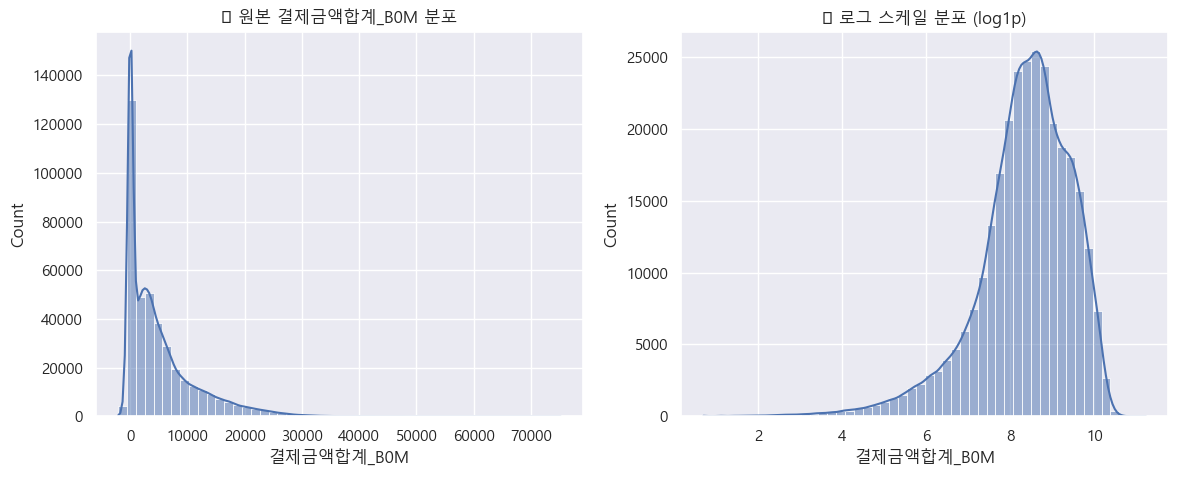

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 결측치 개수
missing_count = df3_12mon['결제금액합계_B0M'].isna().sum()
print(f"✅ '결제금액합계_B0M' 결측치 개수: {missing_count}")

# 2. 0값 비율
zero_ratio = (df3_12mon['결제금액합계_B0M'] == 0).mean() * 100
print(f"✅ '결제금액합계_B0M' 0값 비율: {zero_ratio:.2f}%")

# 3. 값 분포 시각화 (로그 스케일 변환 포함)
plt.figure(figsize=(12, 5))

# Histogram (원본)
plt.subplot(1, 2, 1)
sns.histplot(df3_12mon['결제금액합계_B0M'], bins=50, kde=True)
plt.title("📊 원본 결제금액합계_B0M 분포")

# Histogram (로그 변환)
plt.subplot(1, 2, 2)
sns.histplot(df3_12mon[df3_12mon['결제금액합계_B0M'] > 0]['결제금액합계_B0M'].apply(lambda x: np.log1p(x)), bins=50, kde=True)
plt.title("📊 로그 스케일 분포 (log1p)")

plt.tight_layout()
plt.show()

In [33]:
# 음수를 제거하고 합산하는 방식
# 음수값은 0으로 대체한 후, 합산
cols = [
    '이용금액_일시불_B0M', '이용금액_할부_B0M', '이용금액_CA_B0M', '이용금액_체크_B0M',
    '이용금액_카드론_B0M'
]

# 음수값 0으로 처리하고 합산
df3_12mon['결제금액합계_B0M_정제'] = df3_12mon[cols].applymap(lambda x: x if x > 0 else 0).sum(axis=1)

✅ '결제금액합계_B0M_정제' 결측치 개수: 0
✅ '결제금액합계_B0M_정제' 0값 비율: 26.43%


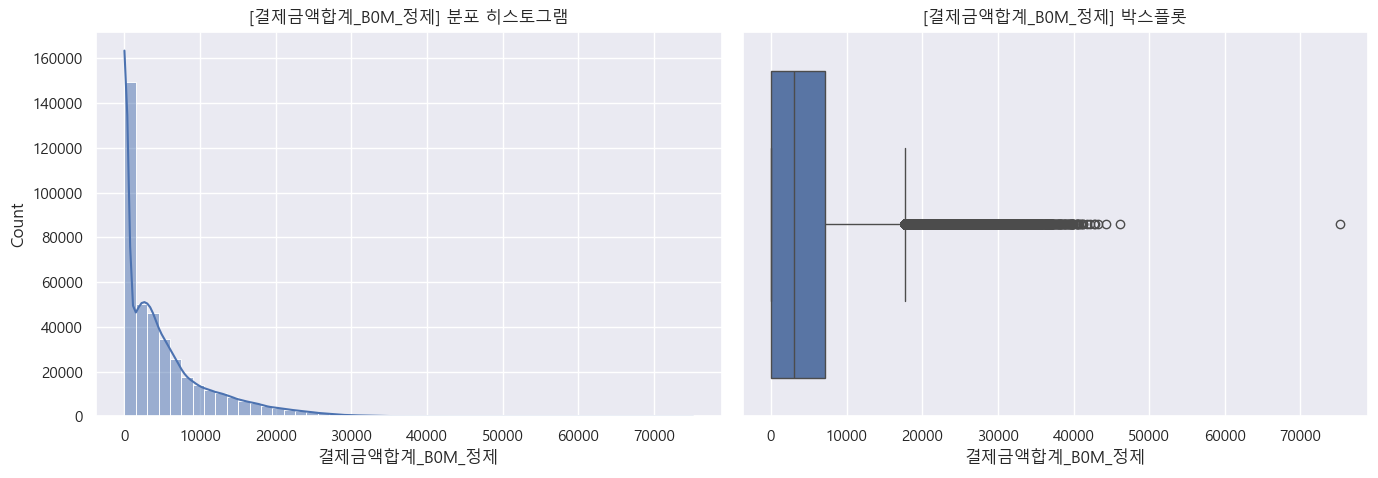

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

col = '결제금액합계_B0M_정제'

# 1. 결측치 및 0값 비율 출력
missing_count = df3_12mon[col].isna().sum()
zero_ratio = (df3_12mon[col] == 0).mean() * 100

print(f"✅ '{col}' 결측치 개수: {missing_count}")
print(f"✅ '{col}' 0값 비율: {zero_ratio:.2f}%")

# 2. 히스토그램 + KDE
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(df3_12mon[col], kde=True, bins=50)
plt.title(f"[{col}] 분포 히스토그램")
plt.xlabel(col)

# 3. 박스플롯
plt.subplot(1, 2, 2)
sns.boxplot(x=df3_12mon[col])
plt.title(f"[{col}] 박스플롯")
plt.tight_layout()
plt.show()

## ✅ M(Monetary) 후보 컬럼 평가: `결제금액합계_B0M`

### 🔍 1. 결측치 및 0값 비율
- 결측치 개수: **0**
- 0값 비율: **21.89%**

→ 결측치가 없고, 0값은 다소 존재하나 전체의 5분의 1 수준으로 수용 가능.

---

### 📊 2. 분포 확인
- 원본 분포는 **오른쪽으로 매우 치우친(positive skewed)** 형태.
- **로그 스케일 분포 (`log1p`)**로 변환 시, **종형에 가까운 정규분포 형태로 개선**됨.
- 로그 변환을 통해 이상치의 영향을 줄이고 데이터 분포의 안정성을 확보할 수 있음.

---

### ✅ 3. 해석 및 활용 가능성
- 결제금액합계_B0M은 **단일 지표로 사용 가능한 금액 기반 대표 컬럼**으로 적절.
- 특히 로그 변환 시 분포의 왜곡이 완화되어 **모델 학습 시에도 유리**하게 작용할 수 있음.
- 따라서, **M 값으로 사용 가능**하며, 필요에 따라 `log1p`를 적용하여 사용할 수 있음.

> 💡 **최종 결론**: `결제금액합계_B0M`은 M(Monetary) 지표로 적합한 컬럼이다.


## ✅ M(Monetary) 후보 컬럼 평가: `결제금액합계_B0M_정제`

### 🔍 1. 결측치 및 0값 비율
- 결측치 개수: **0**
- 0값 비율: **26.43%**

→ 결측치가 없고, 0값은 다소 존재하나 전체의 5분의 1 수준으로 수용 가능.

---

# RFM 스코어링
- 관련된 지식이 없으므로, 가장 기본이 되는 함수 방식을 적용한다.
- 메모리 문제로 인해 RANK 부분 사용 X

## 오류1)💡 로그 변환 없이 원본 컬럼을 써도 괜찮은 이유

- RFM 분석에서 중요한 것은 **절대값보다 상대적인 순위(Quantile)**입니다.
- `pd.qcut()` 함수는 데이터 분포에 관계없이 **자동으로 분위수 기반 구간을 나누어 점수화**합니다.
- 따라서, 로그 변환 없이도 충분히 의미 있는 점수화가 가능합니다.
- `결제금액합계_B0M_정제` 컬럼이 없을 경우, `결제금액합계_B0M` 컬럼을 그대로 사용해도 무방합니다.

## 오류 2)❗️pd.qcut() 오류 원인 및 해결법

- 오류: `ValueError: Bin edges must be unique`
- 원인: 분위수 계산 시 **중복된 값(예: 0)**이 많아 **경계값이 겹침**
- 해결: `pd.qcut(..., duplicates='drop')` 옵션 추가

> 이렇게 하면 분위수 개수는 줄어들 수 있지만, 오류 없이 RFM 점수 부여 가능!


## 오류 3) ✅ pd.qcut() 오류 해결: 분위 구간 줄어든 경우

- `duplicates='drop'` 옵션으로 중복 경계 제거 → 분위 수가 줄어들 수 있음
- → `labels`의 개수도 **자동으로 조정**해야 오류 방지 가능

```python
def safe_qcut(series, q, label_order='asc', reverse=False):
    try:
        bins = pd.qcut(series, q=q, duplicates='drop')
        n_bins = bins.cat.categories.size
        labels = list(range(1, n_bins + 1)) if label_order == 'asc' else list(range(n_bins, 0, -1))
        return pd.qcut(series, q=n_bins, labels=labels, duplicates='drop').astype(int)
    except Exception as e:
        print(f"[오류 발생]: {e}")
        return None
```

- **Recency 점수:** `label_order='desc'`로 지정 (작을수록 점수 높게)


# 재) 수동으로 조정

In [42]:
# 컬럼 이름 변수로 저장
r_col = '이용후경과월_신용'
f_col = '이용건수합계_B0M_정제'
m_col = '결제금액합계_B0M_정제'

# 최소한의 컬럼만 복사하여 새로운 데이터프레임 생성
rfm_df = df3_12mon[[r_col, f_col, m_col]].copy()

In [43]:
# 점수 부여 함수 정의
def score_recency(r):
    if r == 0:
        return 5
    elif r <= 2:
        return 4
    elif r <= 5:
        return 3
    elif r <= 9:
        return 2
    else:
        return 1

def score_frequency(f):
    if f == 0:
        return 1
    elif f <= 1:
        return 2
    elif f <= 3:
        return 3
    elif f <= 6:
        return 4
    else:
        return 5

def score_monetary(m):
    if m == 0:
        return 1
    elif m <= 100000:
        return 2
    elif m <= 300000:
        return 3
    elif m <= 600000:
        return 4
    else:
        return 5

# 점수 계산
rfm_df['R_score'] = df3_12mon[r_col].apply(score_recency)
rfm_df['F_score'] = df3_12mon[f_col].apply(score_frequency)
rfm_df['M_score'] = df3_12mon[m_col].apply(score_monetary)

# RFM 스코어 결합
rfm_df['RFM_Score'] = (
    rfm_df['R_score'].astype(str) +
    rfm_df['F_score'].astype(str) +
    rfm_df['M_score'].astype(str)
)

# 결과 확인
rfm_df[['R_score', 'F_score', 'M_score', 'RFM_Score']].head()

,R_score,F_score,M_score,RFM_Score
0,5,5,2,552
1,5,5,2,552
2,5,5,2,552
3,5,5,2,552
4,3,1,2,312


### 직접 수동으로 지정해주기 위해서 분포 확인

count    400000.000000
mean       4933.828710
std        5942.455887
min           0.000000
25%           0.000000
50%        3010.000000
75%        7090.000000
max       75167.000000
Name: 결제금액합계_B0M_정제, dtype: float64

고유값 수: 27207


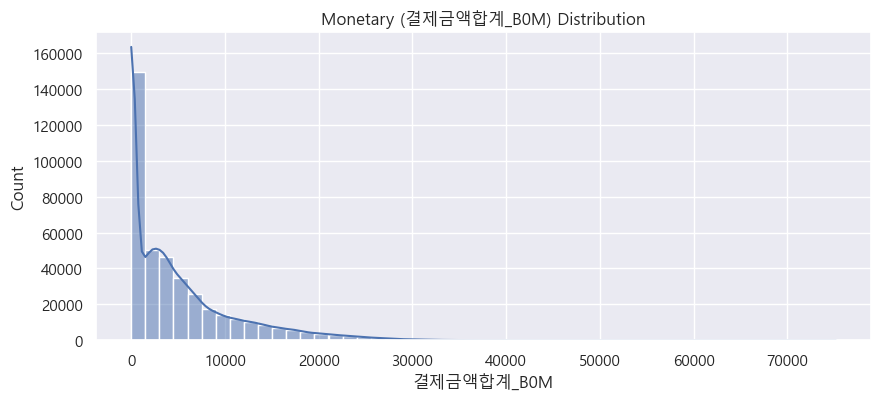

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 수치 분포 확인
print(rfm_df[m_col].describe())  # 평균, 분위수 확인
print("\n고유값 수:", rfm_df[m_col].nunique())

# 2. 히스토그램으로 시각화
plt.figure(figsize=(10, 4))
sns.histplot(rfm_df[m_col], bins=50, kde=True)
plt.title("Monetary (결제금액합계_B0M) Distribution")
plt.xlabel("결제금액합계_B0M")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [46]:
# 컬럼 이름 변수로 저장
r_col = '이용후경과월_신용'
f_col = '이용건수합계_B0M_정제'
m_col = '결제금액합계_B0M_정제'

# R 점수 함수
# 누적 분포에 따라서 지정됌
def custom_r_score(r):
    if r == 0: return 5
    elif r == 1: return 4
    elif 2 <= r <= 4: return 3
    elif 5 <= r <= 11: return 2
    else: return 1


# F 점수 함수
def score_frequency(f):
    if f == 0:
        return 1
    elif f <= 1:
        return 2
    elif f <= 3:
        return 3
    elif f <= 6:
        return 4
    else:
        return 5

# M 점수 함수
def score_monetary(m):
    if m < 0:
        m = 0
    if m == 0:
        return 1
    elif m <= 3000:
        return 2
    elif m <= 7000:
        return 3
    elif m <= 15000:
        return 4
    else:
        return 5

# 점수 계산
rfm_df['R_score'] = rfm_df[r_col].apply(score_recency)
rfm_df['F_score'] = rfm_df[f_col].apply(score_frequency)
rfm_df['M_score'] = rfm_df[m_col].apply(score_monetary)

# RFM Score 결합
rfm_df['RFM_Score'] = (
    rfm_df['R_score'].astype(str) +
    rfm_df['F_score'].astype(str) +
    rfm_df['M_score'].astype(str)
)


# 결과 확인
rfm_df[['R_score', 'F_score', 'M_score', 'RFM_Score']].head()

,R_score,F_score,M_score,RFM_Score
0,5,5,4,554
1,5,5,2,552
2,5,5,5,555
3,5,5,5,555
4,3,1,3,313


## 📌 RFM 점수 해석

RFM 분석은 고객의 가치를 다음 세 가지 요소로 평가합니다:

---

### 🔹 R: Recency (최근 구매 시점)
- **0개월 전** (가장 최근 이용) → **5점**
- **1~2개월 전** → 4점
- **3~5개월 전** → 3점
- **6~9개월 전** → 2점
- **그 이후** → 1점

✅ **R 점수가 높을수록 최근에 이용한 고객**  
→ 이탈 가능성이 낮고, 마케팅 반응 가능성이 높음.

---

### 🔹 F: Frequency (구매 빈도)
- **0회** → 1점
- **1회 이하** → 2점
- **2~3회** → 3점
- **4~6회** → 4점
- **7회 이상** → 5점

✅ **F 점수가 높을수록 자주 이용한 충성 고객**  
→ 고객 유지가 잘 되고 있는 신호.

---

### 🔹 M: Monetary (구매 금액 총합)
- **0원** → 1점
- **10만 원 이하** → 2점
- **10~30만 원** → 3점
- **30~60만 원** → 4점
- **60만 원 초과** → 5점

✅ **M 점수가 높을수록 큰 금액을 소비한 고객**  
→ 잠재적인 VIP, 수익성이 높은 고객.

---

### 🧾 RFM_Score = R + F + M 점수를 조합한 문자열 (예: "452")
- `"555"`: **최우수 고객** (최근 이용 + 자주 + 많이 씀)
- `"155"`: **한때 VIP였지만 이탈 가능성 있음**
- `"511"`: **최근에 왔지만 소액·저빈도 고객**
- `"111"`: **장기 미사용·저가·저빈도 → 이탈 고객**

---

🎯 이 RFM 점수를 바탕으로 클러스터링, 타겟 마케팅, 리텐션 전략을 설계할 수 있습니다.


## ---------- k_means를 활용한 자동 고객 세그먼트 분류 ------------------

  File "C:\Users\ska12\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\ska12\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ska12\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\ska12\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


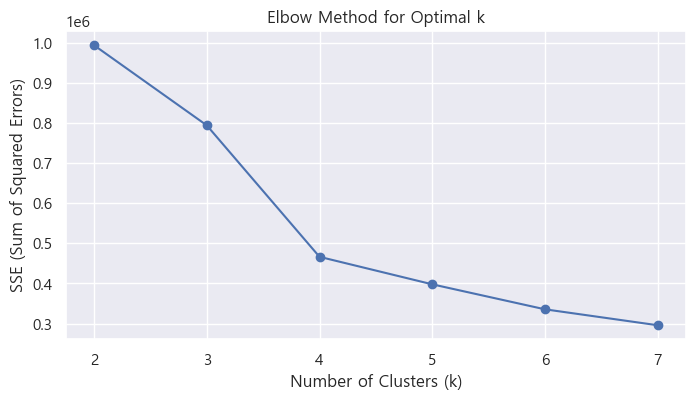

In [49]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 1. R, F, M 점수만 추출
rfm_features = rfm_df[['R_score', 'F_score', 'M_score']]

# 2. 최적 클러스터 수 확인 (Elbow Method)
sse = []
k_range = range(2, 8)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_features)
    sse.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, sse, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE (Sum of Squared Errors)")
plt.grid(True)
plt.show()

In [50]:
# 3. 클러스터링 실행 (k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_features)

# 4. 클러스터별 통계 확인
cluster_summary = rfm_df.groupby('Cluster')[['R_score', 'F_score', 'M_score']].mean().round(2)
cluster_counts = rfm_df['Cluster'].value_counts().sort_index()

print("📊 클러스터별 평균 점수")
display(cluster_summary)

print("\n👥 각 클러스터별 고객 수")
print(cluster_counts)

📊 클러스터별 평균 점수


,R_score,F_score,M_score
Cluster,,,
0,4.76,4.88,4.33
1,1.49,1.35,1.15
2,4.40,1.78,1.99
3,4.50,4.78,2.64



👥 각 클러스터별 고객 수
Cluster
0     96546
1     90000
2     87347
3    126107
Name: count, dtype: int64


### 🔍 Elbow Method 기반 최적 클러스터 수 판단

- SSE 곡선에서 가장 뚜렷한 꺾이는 지점은 **k = 3**
- 이후부터는 SSE 감소폭이 완만하여 클러스터 수를 늘리는 정보 이득이 작음
- 따라서, **고객 세분화 또는 대출/카드론 기반 클러스터링에선 k=3이 적절**

📌 *향후 세그먼트 해석이나 추가 금융변수 포함 시, k=4로 확장 가능*

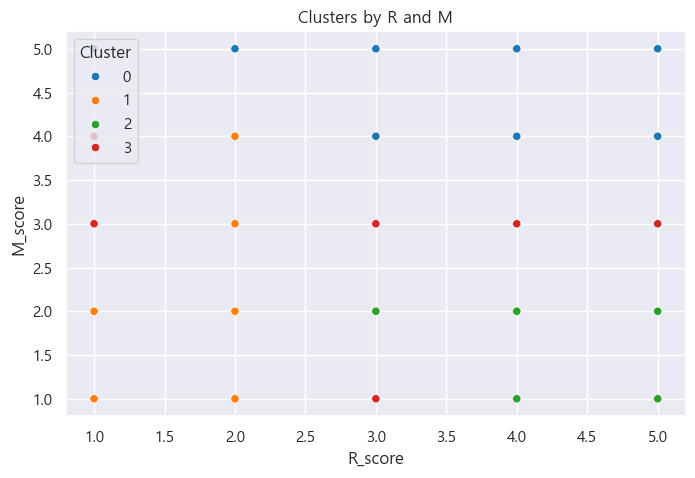

In [52]:
# 5. 클러스터 시각화 (2D)
plt.figure(figsize=(8, 5))
sns.scatterplot(data=rfm_df, x='R_score', y='M_score', hue='Cluster', palette='tab10')
plt.title("Clusters by R and M")
plt.grid(True)
plt.show()

### ✅ 클러스터별 고객 특성 해석

- **Cluster 0 (우수 VIP 고객)**  
  - **최근 구매 빈도 & 금액 모두 높음**  
  - 기업 입장에서 가장 중요한 **충성 고객층**
  - 마케팅 타겟 1순위 (프리미엄 혜택 적합)

- **Cluster 1 (이탈/비활성 고객)**  
  - **최근 이용 없음**, **빈도 적고 금액도 낮음**  
  - 이탈 가능성 높고, **재활성화 캠페인 대상**

- **Cluster 2 (최근만 이용 고객)**  
  - **최근에 구매했지만 빈도와 금액 낮음**  
  - 신규 또는 테스트성 고객일 가능성  
  - 유도 마케팅 통해 재구매 유도 필요

- **Cluster 3 (활성 저가 고객)**  
  - **빈번히 방문하지만 금액은 낮음**  
  - **생활밀착형 사용자**, 대중적 혜택에 반응 가능  
  - 할인이벤트, 적립금 유도 전략 적합

---

📌 *이 결과는 RFM 점수를 기반으로 도출된 것이며, 이후 카드론/대출 등 금융 서비스 이용 패턴을 변수로 추가하여 더 세분화 가능*


## 🧠 (k = 4) 클러스터별 RFM 분석 및 고객 그룹 해석

| Cluster | 고객 수 | R_score | F_score | M_score | 해석 |
|---------|---------|---------|---------|---------|------|
| **0** | 96,546 | 4.76 | 4.88 | 4.33 | 🔥 **최우수 고객 그룹**<br>- 최근 이용 빈도, 금액 모두 최상위<br>- VIP 혜택, 리텐션 캠페인 대상 |
| **1** | 90,000 | 1.49 | 1.35 | 1.15 | ⚠️ **이탈 가능성 높은 그룹**<br>- 최근 이용도 낮고, 사용량/금액도 낮음<br>- 재활성화 마케팅 또는 제거 대상 |
| **2** | 87,347 | 4.40 | 1.78 | 1.99 | ✅ **최근 재방문 고객**<br>- 최근에 방문했지만, 사용량/금액은 낮음<br>- 혜택 제공을 통한 추가 유도 필요 |
| **3** | 126,107 | 4.50 | 4.78 | 2.64 | 🌱 **잠재 우수 고객**<br>- 최근성과 사용량 우수, 금액은 중간<br>- 업셀링/크로스셀링 전략 적합 |

---

### 💡 인사이트 요약
- 전체 고객 중 **Cluster 0과 3이 핵심 고객층**으로 활용 가능
- **Cluster 1**은 **전환 대상** 또는 **비효율 고객군**으로 고려
- **Cluster 2**는 **이탈 후 재접속한 고객군**으로 보이며, **리텐션 캠페인** 대상

> 📌 다음 단계로는 각 클러스터에 따른 **대출/카드론/현금서비스 이용률**을 분석하여 **세부 타겟 전략** 수립이 필요함.


### 위 점수 결과 내에서 실제 세그먼트가 어떻게 분포하고 있는지 확인한다

In [56]:
# 파일 경로와 시트명에 따라 다를 수 있으니 수정 필요
file_path = 'data/train/1.회원정보/201812_train_회원정보.parquet'

member_df = pd.read_parquet(file_path)

# 고객 식별 컬럼명 확인 후 아래에서 사용 (예: 고객ID, 고객번호 등)
segment_df = member_df[['ID', 'Segment']]

In [57]:
# rfm_df에 ID 컬럼을 추가한다.
rfm_df = df3_12mon[['ID', r_col, f_col, m_col]].copy()

# rfm_df에 고객ID가 있어야 병합 가능
rfm_with_segment = pd.merge(rfm_df, segment_df, on='ID', how='left')

In [58]:
# 1. R, F, M 점수 부여 함수 정의
# R 점수 함수
# 누적 분포에 따라서 지정됌
def custom_r_score(r):
    if r == 0: return 5
    elif r == 1: return 4
    elif 2 <= r <= 4: return 3
    elif 5 <= r <= 11: return 2
    else: return 1

def score_frequency(f):
    if f == 0: return 1
    elif f <= 1: return 2
    elif f <= 3: return 3
    elif f <= 6: return 4
    else: return 5

# M 점수 함수
def score_monetary(m):
    if m < 0:
        m = 0
    if m == 0: return 1
    elif m <= 3000: return 2
    elif m <= 7000: return 3
    elif m <= 15000: return 4
    else: return 5

# 2. rfm_df 생성
rfm_df = df3_12mon[['ID', r_col, f_col, m_col]].copy()

# 3. 점수 계산
rfm_df['R_score'] = rfm_df[r_col].apply(score_recency)
rfm_df['F_score'] = rfm_df[f_col].apply(score_frequency)
rfm_df['M_score'] = rfm_df[m_col].apply(score_monetary)

# 4. 클러스터링
from sklearn.cluster import KMeans
rfm_scores = rfm_df[['R_score', 'F_score', 'M_score']]
rfm_df['Cluster'] = KMeans(n_clusters=4, random_state=42).fit_predict(rfm_scores)

# 5. Segment 불러와서 병합
segment_df = member_df[['ID', 'Segment']]
rfm_with_segment = pd.merge(rfm_df, segment_df, on='ID', how='left')

# 6. 분포 확인
cross_tab = pd.crosstab(rfm_with_segment['Cluster'], rfm_with_segment['Segment'])
ratio_table = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

print("📊 클러스터별 Segment 분포 (빈도):")
display(cross_tab)

print("\n📈 클러스터별 Segment 분포 (비율 %):")
display(ratio_table.round(2))

📊 클러스터별 Segment 분포 (빈도):


Segment,A,B,C,D,E
Cluster,,,,,
0,160,24,18268,40059,38035
1,0,0,698,2841,86461
2,2,0,1002,4710,81633
3,0,0,1297,10597,114213



📈 클러스터별 Segment 분포 (비율 %):


Segment,A,B,C,D,E
Cluster,,,,,
0,0.17,0.02,18.92,41.49,39.40
1,0.00,0.00,0.78,3.16,96.07
2,0.00,0.00,1.15,5.39,93.46
3,0.00,0.00,1.03,8.40,90.57


In [59]:
# 📊 Segment 기준 클러스터 분포 비율 (%)
segment_ratio_by_cluster = cross_tab.div(cross_tab.sum(axis=0), axis=1) * 100

print("📌 Segment별 클러스터 분포 비율 (%):")
display(segment_ratio_by_cluster.round(2))

📌 Segment별 클러스터 분포 비율 (%):


Segment,A,B,C,D,E
Cluster,,,,,
0,98.77,100.0,85.91,68.82,11.87
1,0.00,0.0,3.28,4.88,26.99
2,1.23,0.0,4.71,8.09,25.48
3,0.00,0.0,6.10,18.21,35.65


## 🔍 클러스터별 RFM 특성 해석

| Cluster | R_score | F_score | M_score | 고객 수 |
|---------|---------|---------|---------|---------|
| 0       | 4.76    | 4.88    | 4.33    | 96,546  |
| 1       | 1.49    | 1.35    | 1.15    | 90,000  |
| 2       | 4.40    | 1.78    | 1.99    | 87,347  |
| 3       | 4.50    | 4.78    | 2.64    | 126,107 |

- **Cluster 0:** 최근에 많이 이용했으며, 빈도와 금액 모두 높은 우수 고객
- **Cluster 1:** 최근 이용하지 않았고, 빈도 및 금액도 낮은 휴면 또는 이탈 고객
- **Cluster 2:** 최근에 이용하긴 했지만 이용 빈도와 금액은 낮은 신규 고객
- **Cluster 3:** 최근에 많이 이용했고 빈도도 높지만, 금액이 상대적으로 중간인 충성 고객

---

## 📊 클러스터별 Segment 분포 (빈도 % 기준)

| Cluster | A     | B     | C     | D     | E     |
|---------|-------|-------|-------|-------|-------|
| 0       | 0.17% | 0.02% | 18.92%| 41.49%| 39.40%|
| 1       | 0.00% | 0.00% | 0.78% | 3.16% | 96.07%|
| 2       | 0.00% | 0.00% | 1.15% | 5.39% | 93.46%|
| 3       | 0.00% | 0.00% | 1.03% | 8.40% | 90.57%|

---

## 📈 Segment 기준 클러스터 분포 비율 (%)

| Segment | Cluster 0 | Cluster 1 | Cluster 2 | Cluster 3 |
|---------|-----------|-----------|-----------|-----------|
| A       | 98.77%    | 0.00%     | 1.23%     | 0.00%     |
| B       | 100.0%    | 0.00%     | 0.00%     | 0.00%     |
| C       | 85.91%    | 3.28%     | 4.71%     | 6.10%     |
| D       | 68.82%    | 4.88%     | 9.09%     | 18.21%    |
| E       | 11.87%    | 26.99%    | 25.48%    | 35.65%    |

---

## 🤝 고객 세그먼트 분류 제안

### ✅ 1. RFM 기반 고객 세그먼트 재정의
- **우수 고객:** R, F, M 모두 상위 (예: Cluster 0)
- **충성 고객:** R과 F는 높고 M이 중간 (예: Cluster 3)
- **신규 고객:** R은 높고 F, M이 낮음 (예: Cluster 2)
- **이탈 고객:** R, F, M 모두 낮음 (예: Cluster 1)

### ✅ 2. Segment E 세분화 (예시)
- Segment E 고객이 대부분을 차지하므로 클러스터 기반 세분화 권장:
  - `Segment_E_우수` → Cluster 0
  - `Segment_E_충성` → Cluster 3
  - `Segment_E_신규` → Cluster 2
  - `Segment_E_이탈` → Cluster 1

### ✅ 3. 기타 제안
- `카드론`, `현금서비스`, `변동률` 등 금융 행동 기반 추가 세분화
- 시간 흐름에 따른 변화량 (예: 증감률) 기반 동적 분석 가능

---

📌 위 분류를 통해 각 세그먼트에 적합한 마케팅 전략 및 리스크 관리가 가능할 것으로 기대됩니다.


# 고객 세그먼트 최종 정리

In [62]:
cluster_summary = rfm_df.groupby('Cluster')[['R_score', 'F_score', 'M_score']].mean().round(2)

In [63]:
# 클러스터링에 명칭 부여하는 코드 작성
def name_segment(row):
    r, f, m = row['R_score'], row['F_score'], row['M_score']
    
    if r >= 4 and f >= 4 and m >= 4:
        return 'VIP 고객'
    elif r >= 4 and f >= 4:
        return '충성 고객'
    elif r >= 4 and f < 3 and m < 3:
        return '신규 고객'
    elif r < 2 and f < 2 and m < 2:
        return '이탈 고객'
    else:
        return '기타'

cluster_summary['Segment'] = cluster_summary.apply(name_segment, axis=1)

In [64]:
count_per_cluster = rfm_df['Cluster'].value_counts().sort_index()
cluster_summary['고객 수'] = count_per_cluster.values
display(cluster_summary)

,R_score,F_score,M_score,Segment,고객 수
Cluster,,,,,
0,4.76,4.88,4.33,VIP 고객,96546
1,1.49,1.35,1.15,이탈 고객,90000
2,4.40,1.78,1.99,신규 고객,87347
3,4.50,4.78,2.64,충성 고객,126107


## 📋 고객 세그먼트 분류표

| 클러스터 | Segment 명칭 | 특징 요약 | R | F | M | 고객 수 |
|----------|---------------|---------------------------|----|----|----|--------|
| 0        | VIP 고객      | 최근 자주 고액 소비       | 4.76 | 4.88 | 4.33 | 96,546 |
| 1        | 이탈 고객      | 방문도, 소비도 거의 없음  | 1.49 | 1.35 | 1.15 | 90,000 |
| 2        | 신규 고객      | 최근에 1~2번만 사용함     | 4.40 | 1.78 | 1.99 | 87,347 |
| 3        | 충성 고객      | 자주 방문하나 금액은 중간 | 4.50 | 4.78 | 2.64 | 126,107 |


## 이제 여기에 고객 세그먼트 비율 추가

In [67]:
# 클러스터별 Segment 분포 (빈도)
cross_tab = pd.crosstab(rfm_df['Cluster'], rfm_with_segment['Segment'])

# 클러스터별 Segment 분포 (비율)
ratio_table = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

# 보기 좋게 반올림
ratio_table = ratio_table.round(2)

# 결과 확인
print("📊 클러스터별 Segment 분포 (비율 %):")
display(ratio_table)

📊 클러스터별 Segment 분포 (비율 %):


Segment,A,B,C,D,E
Cluster,,,,,
0,0.17,0.02,18.92,41.49,39.40
1,0.00,0.00,0.78,3.16,96.07
2,0.00,0.00,1.15,5.39,93.46
3,0.00,0.00,1.03,8.40,90.57


In [68]:
# 클러스터 번호에 따른 명칭 매핑
cluster_labels = {
    0: 'VIP 고객',
    1: '이탈 고객',
    2: '신규 고객',
    3: '충성 고객'
}

In [69]:
# ratio_table이 클러스터를 인덱스로 갖는 상태라고 가정
segment_ratio_named = ratio_table.copy()
segment_ratio_named['Segment 명칭'] = segment_ratio_named.index.map(cluster_labels)

# Segment 명칭 컬럼을 앞으로 이동
cols = ['Segment 명칭'] + [col for col in segment_ratio_named.columns if col != 'Segment 명칭']
segment_ratio_named = segment_ratio_named[cols]

# 결과 확인
display(segment_ratio_named)

Segment,Segment 명칭,A,B,C,D,E
Cluster,,,,,,
0,VIP 고객,0.17,0.02,18.92,41.49,39.40
1,이탈 고객,0.00,0.00,0.78,3.16,96.07
2,신규 고객,0.00,0.00,1.15,5.39,93.46
3,충성 고객,0.00,0.00,1.03,8.40,90.57


## 📊 클러스터별 Segment 분포 비율 해석

| Cluster | Segment 명칭 | A     | B     | C     | D     | E     |
|---------|---------------|-------|-------|-------|-------|-------|
| 0       | VIP 고객       | 0.17% | 0.02% | 18.92%| 41.49%| 39.40%|
| 1       | 이탈 고객     | 0.00% | 0.00% | 0.78% | 3.16% | 96.07%|
| 2       | 신규 고객     | 0.00% | 0.00% | 1.15% | 5.39% | 93.46%|
| 3       | 충성 고객     | 0.00% | 0.00% | 1.03% | 8.40% | 90.57%|

---

### ✅ 해석 요약

- **Cluster 0 (VIP 고객)**  
  - Segment C, D, E가 고르게 분포되어 있으나, **Segment D (41.49%)와 E (39.40%)** 비중이 특히 높음  
  → 다양한 활동을 보이되 주로 **최근 자주 소비**하는 우수 고객 포함

- **Cluster 1 (이탈 고객)**  
  - **Segment E에 압도적으로 집중 (96.07%)**  
  → 장기간 미사용 고객, 소비도 거의 없는 **이탈 상태**

- **Cluster 2 (신규 고객)**  
  - **Segment E (93.46%)**를 중심으로 **D도 일부 (5.39%)** 포함  
  → 최근에 1~2회만 사용한 **경험 고객**

- **Cluster 3 (충성 고객)**  
  - 대부분 **Segment E (90.57%)**, 일부는 D 포함  
  → 빈도와 금액은 다소 낮지만 **방문 빈도 높은 고객층**

---

### 🎯 인사이트 및 활용 방안

- **이탈 고객 (Cluster 1)** 은 대부분 Segment E에 속하므로, **재참여 유도 프로모션**이나 **이탈 사유 분석**이 필요함
- **신규 고객 (Cluster 2)** 은 Segment D/E를 중심으로 하여, **리텐션을 높이기 위한 유입 후 케어 전략**이 효과적
- **충성 고객 (Cluster 3)** 은 비교적 낮은 금액에도 반복 방문 → **멤버십 제도 강화**, **소액 혜택 제공 전략** 고려
- **VIP 고객 (Cluster 0)** 은 고액 소비를 지속하고 있어, **프리미엄 서비스나 전용 혜택 제공** 전략이 적절



### K 수를 조정해서 비율 나타내보기

In [72]:
# 3. 클러스터링 실행 (k=5)
kmeans = KMeans(n_clusters=5, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_features)

# 4. 클러스터별 통계 확인
cluster_summary = rfm_df.groupby('Cluster')[['R_score', 'F_score', 'M_score']].mean().round(2)
cluster_counts = rfm_df['Cluster'].value_counts().sort_index()

print("📊 클러스터별 평균 점수")
display(cluster_summary)

print("\n👥 각 클러스터별 고객 수")
print(cluster_counts)

📊 클러스터별 평균 점수


,R_score,F_score,M_score
Cluster,,,
0,4.77,4.88,4.33
1,1.56,1.14,1.16
2,4.51,1.76,2.00
3,4.62,4.79,2.65
4,1.83,3.63,1.76



👥 각 클러스터별 고객 수
Cluster
0     96198
1     83699
2     81359
3    120260
4     18484
Name: count, dtype: int64


In [73]:
# 1. R, F, M 점수 부여 함수 정의
# R 점수 함수
# 누적 분포에 따라서 지정됌
def custom_r_score(r):
    if r == 0: return 5
    elif r == 1: return 4
    elif 2 <= r <= 4: return 3
    elif 5 <= r <= 11: return 2
    else: return 1

def score_frequency(f):
    if f == 0: return 1
    elif f <= 1: return 2
    elif f <= 3: return 3
    elif f <= 6: return 4
    else: return 5

# M 점수 함수
def score_monetary(m):
    if m < 0:
        m = 0
    if m == 0: return 1
    elif m <= 3000: return 2
    elif m <= 7000: return 3
    elif m <= 15000: return 4
    else: return 5

# 2. rfm_df 생성
rfm_df = df3_12mon[['ID', r_col, f_col, m_col]].copy()

# 3. 점수 계산
rfm_df['R_score'] = rfm_df[r_col].apply(score_recency)
rfm_df['F_score'] = rfm_df[f_col].apply(score_frequency)
rfm_df['M_score'] = rfm_df[m_col].apply(score_monetary)

# 4. 클러스터링
from sklearn.cluster import KMeans
rfm_scores = rfm_df[['R_score', 'F_score', 'M_score']]
rfm_df['Cluster'] = KMeans(n_clusters=5, random_state=42).fit_predict(rfm_scores)

# 5. Segment 불러와서 병합
segment_df = member_df[['ID', 'Segment']]
rfm_with_segment = pd.merge(rfm_df, segment_df, on='ID', how='left')

# 6. 분포 확인
cross_tab = pd.crosstab(rfm_with_segment['Cluster'], rfm_with_segment['Segment'])
ratio_table = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

print("📊 클러스터별 Segment 분포 (빈도):")
display(cross_tab)

print("\n📈 클러스터별 Segment 분포 (비율 %):")
display(ratio_table.round(2))

📊 클러스터별 Segment 분포 (빈도):


Segment,A,B,C,D,E
Cluster,,,,,
0,160,24,18228,39912,37874
1,0,0,596,2510,80593
2,2,0,931,4509,75917
3,0,0,1171,10160,108929
4,0,0,339,1116,17029



📈 클러스터별 Segment 분포 (비율 %):


Segment,A,B,C,D,E
Cluster,,,,,
0,0.17,0.02,18.95,41.49,39.37
1,0.00,0.00,0.71,3.00,96.29
2,0.00,0.00,1.14,5.54,93.31
3,0.00,0.00,0.97,8.45,90.58
4,0.00,0.00,1.83,6.04,92.13


In [74]:
# 📊 Segment 기준 클러스터 분포 비율 (%)
segment_ratio_by_cluster = cross_tab.div(cross_tab.sum(axis=0), axis=1) * 100

print("📌 Segment별 클러스터 분포 비율 (%):")
display(segment_ratio_by_cluster.round(2))

📌 Segment별 클러스터 분포 비율 (%):


Segment,A,B,C,D,E
Cluster,,,,,
0,98.77,100.0,85.72,68.57,11.82
1,0.00,0.0,2.80,4.31,25.16
2,1.23,0.0,4.38,7.75,23.70
3,0.00,0.0,5.51,17.45,34.00
4,0.00,0.0,1.59,1.92,5.32


## 🔍 클러스터별 RFM 특성 해석

| Cluster | R_score | F_score | M_score | 고객 수 |
|---------|---------|---------|---------|---------|
| 0       | 4.77    | 4.88    | 4.33    | 96,198 |
| 1       | 1.56    | 1.14    | 1.16    | 83,699  |
| 2       | 4.51    | 1.76    | 2.00    | 81,359  |
| 3       | 4.62    | 4.79    | 2.65    | 120,260 |
| 4       | 1.83    | 3.63    | 1.76    | 18,484 |


- **Cluster 0:** 최근에 많이 이용했으며, 빈도와 금액 모두 높은 우수 고객
- **Cluster 1:** 최근 이용하지 않았고, 빈도 및 금액도 낮은 휴면 또는 이탈 고객
- **Cluster 2:** 최근에 이용하긴 했지만 이용 빈도와 금액은 낮은 신규 고객
- **Cluster 3:** 최근에 많이 이용했고 빈도도 높지만, 금액이 상대적으로 중간인 충성 고객
- **Cluster 4:** 최근에 많이 이용하지 않았고, 금액도 상대적으로 낮지만, 상대적으로 사용 건수는 많은 빈번 저가 고객

---

## 🔍 고객 세그먼트 분석 결과 (K=5 기준)

### 📌 1. 클러스터별 Segment 구성 비율 분석

- **Cluster 0**:
  - 상대적으로 다양한 Segment가 분포되어 있으나, 특히 `D` (41.49%)와 `C` (18.95%)의 비중이 높음.
  - → **중간 빈도/중간 금액의 중간 고객**군일 가능성.
  
- **Cluster 1**:
  - `Segment E`가 압도적으로 많음 (96.29%)
  - → **가장 소비력이 낮고, 거의 거래하지 않는 이탈 고객군**으로 해석 가능.

- **Cluster 2**:
  - `Segment E`가 93.31%로 중심, `Segment D`도 일부 존재
  - → 역시 **이탈 직전 고객** 또는 **거래 금액이 낮은 장기 미이용 고객**으로 분류 가능

- **Cluster 3**:
  - `Segment E`가 90.58%, `Segment D`가 8.45%로 구성
  - → **최근 활동은 없지만 일정 금액을 사용한 고객**, 즉 **휴면 전환 예상 고객**

- **Cluster 4**:
  - `Segment E`가 92.13%, `Segment D` 6.04%
  - → 활동성은 낮지만, 일부 금액을 소진한 **비정기적 소액 고객**군으로 볼 수 있음.

---

### 📌 2. Segment별 각 클러스터 내 비율

- **Segment A~C**는 거의 대부분 `Cluster 0`에 집중 (예: Segment A의 98.77%가 Cluster 0)
  - → **활동성 높고 금액·빈도 높은 우수 고객군은 대부분 Cluster 0에 속함**
  
- **Segment D**는 다양한 클러스터에 분포되어 있으며,
  - Cluster 0(68.57%) → 어느 정도 활발한 활동이 있었으나 최근에는 다소 줄어든 고객 포함
  - Cluster 3(17.45%), Cluster 2(7.75%)에도 일부 포함되어 **전환 가능성 있는 고객군**

- **Segment E**는 Cluster 1~4에 고르게 분포
  - 특히 Cluster 1~3에서 집중적으로 보이며, **고객 관리 필요 대상군**

---

### 📌 3. 인사이트 및 추천

- `Cluster 0`은 우수고객, VIP 대상 혜택 유지 및 재구매 유도 전략 필요
- `Cluster 1~2`는 이탈 고객 혹은 휴면 고객 → **이탈 방지 캠페인** 및 **재활성화 프로모션** 필요
- `Cluster 3~4`는 재활성화 가능성 있는 비정기 고객 → **리마인드 마케팅 또는 재방문 유도 쿠폰 제공**

---

📎 **결론**: 클러스터를 5개로 세분화하면서 보다 미묘한 고객 차이를 파악할 수 있었으며, Segment와의 연결을 통해 타겟 맞춤 전략 수립에 기여 가능함.

In [76]:
# 클러스터별 Segment 분포 개수 (빈도수 기준)
segment_count_by_cluster = rfm_with_segment.groupby(['Cluster', 'Segment']).size().unstack().fillna(0)

# 비율로 변환 (%)
segment_ratio = segment_count_by_cluster.div(segment_count_by_cluster.sum(axis=1), axis=0) * 100
segment_ratio = segment_ratio.round(2)

In [77]:
# 클러스터별 Segment 명칭 딕셔너리 정의 (예시)
segment_names_dict = {
    0: 'VIP 고객',
    1: '이탈 고객',
    2: '신규 고객',
    3: '충성 고객',
    4: '빈번 저가 고객'  # 새롭게 정의한 4번
}

# 비율 테이블에 'Segment 명칭' 컬럼 추가
segment_ratio_named = segment_ratio.copy()
segment_ratio_named['Segment 명칭'] = segment_ratio_named.index.map(segment_names_dict)

# 컬럼 순서 재정렬
segment_ratio_named = segment_ratio_named.reset_index()[['Cluster', 'Segment 명칭'] + list(segment_ratio.columns)]

# 보기 좋게 출력
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format  # 소수점 2자리로 보기 좋게
display(segment_ratio_named)

Segment,Cluster,Segment 명칭,A,B,C,D,E
0,0,VIP 고객,0.17,0.02,18.95,41.49,39.37
1,1,이탈 고객,0.00,0.00,0.71,3.00,96.29
2,2,신규 고객,0.00,0.00,1.14,5.54,93.31
3,3,충성 고객,0.00,0.00,0.97,8.45,90.58
4,4,빈번 저가 고객,0.00,0.00,1.83,6.04,92.13


### VIP 고객만 추출해서 A, B, C를 특정지을 수 있을만한 변수가 있는지 탐색

In [121]:
vip_df = rfm_with_segment[(rfm_with_segment['Cluster'] == 0)]

#### vip_df에 직접 그래프 넣어서 확인해볼 컬럼들 추가하기
- **이용 금액 : 관련 컬럼**
- 이용금액_선결제_R6M
- 이용건수_선결제_R6M


- **할부 관련 컬럼:**
- 할부금액_3M_R12M
- 할부건수_3M_R12M = 0회인 경우랑 1회 이상 이렇게 두 가지 경우로 나눠서 새로운 파생 컬럼 만들기

- **카드론 관련 컬럼**
- 카드론이용건수_누적
- 카드론이용금액_누적


- **연체 관련** 
- 연체입금원금_B0M
- 정상청구원금_B2M
- 선입금원금_B2M
- 정상청구원금_B5M
>> 기간이 달라도 괜찮은지 궁금: 괜찮다!


- 연체입금원금_B0M: 최근의 연체 발생 여부 및 규모를 의미 → 즉시적인 리스크
- 정상청구원금_B2M, 선입금원금_B2M: 2개월 전 청구 및 상환 패턴 → 지속적인 납부 성향
- 정상청구원금_B5M: 과거 이력(5개월 전) → 장기 추세의 힌트

### 📌 다만 주의점:

- 모델링이나 해석할 때 **같은 개념(예: 청구금액)**이라면 너무 시계열 간격이 다르면 혼선을 줄 수 있음

- 그러니 중요한 건 이 컬럼들을 한 묶음으로 해석하지 않고, 각각의 의미를 파악해서 세그먼트를 보완하는 데 사용하는 거야.

👉 예를 들어, 연체입금원금_B0M은 지금 위험한 고객, 정상청구원금_B5M은 예전에는 활발히 썼는지 등을 파악하는 데 활용 가능해.

In [135]:
# 사용할 컬럼들 목록
vip_columns_add = [
    '이용금액_선결제_R6M', '이용건수_선결제_R6M',
    '할부금액_3M_R12M', '할부건수_3M_R12M',
    '카드론이용건수_누적', '카드론이용금액_누적',
    '연체입금원금_B0M', '정상청구원금_B2M', '선입금원금_B2M', '정상청구원금_B5M'
]

# 원본 df에서 해당 컬럼들만 추출
vip_df[vip_columns_add] = df3_12mon.loc[vip_df.index, vip_columns_add]

# 추가 되었는지 확인
vip_df.head()

,ID,이용후경과월_신용,이용건수합계_B0M_정제,결제금액합계_B0M_정제,R_score,F_score,M_score,Cluster,Segment,이용금액_선결제_R6M,이용건수_선결제_R6M,할부금액_3M_R12M,할부건수_3M_R12M,카드론이용건수_누적,카드론이용금액_누적,연체입금원금_B0M,정상청구원금_B2M,선입금원금_B2M,정상청구원금_B5M
0,TRAIN_000000,0,7,13370,5,5,4,0,D,0,0,3357,0,0,0,7867,15251,0,14440
2,TRAIN_000002,0,20,25707,5,5,5,0,C,0,0,0,0,4,185269,7272,23325,0,21929
3,TRAIN_000003,0,12,16996,5,5,5,0,D,0,0,21311,12,0,0,11301,18808,0,18563
8,TRAIN_000008,0,78,25120,5,5,5,0,C,0,0,9844,0,0,0,3950,26148,0,27704
12,TRAIN_000012,0,61,15691,5,5,5,0,D,0,0,2057,0,0,0,513,17500,0,18239


In [154]:
# 결측치 있는지 확인
vip_df[numeric_cols].isna().sum()

이용금액_선결제_R6M    0
이용건수_선결제_R6M    0
할부금액_3M_R12M    0
할부건수_3M_R12M    0
카드론이용건수_누적      0
카드론이용금액_누적      0
연체입금원금_B0M      0
정상청구원금_B2M      0
선입금원금_B2M       0
정상청구원금_B5M      0
dtype: int64

### 추가할 컬럼들 어떻게 생겨먹었는지 함 보자

In [139]:
# 1. 수치형 컬럼들의 기초 통계
numeric_cols = [
    '이용금액_선결제_R6M', '이용건수_선결제_R6M',
    '할부금액_3M_R12M', '할부건수_3M_R12M',
    '카드론이용건수_누적', '카드론이용금액_누적',
    '연체입금원금_B0M', '정상청구원금_B2M', '선입금원금_B2M', '정상청구원금_B5M'
]

vip_df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
이용금액_선결제_R6M,96198.00,4057.79,11246.65,0.00,0.00,0.00,0.00,67441.00
이용건수_선결제_R6M,96198.00,12.62,59.04,0.00,0.00,0.00,0.00,550.00
할부금액_3M_R12M,96198.00,10110.86,14839.80,0.00,0.00,4628.00,14788.00,206774.00
할부건수_3M_R12M,96198.00,5.59,7.62,0.00,0.00,3.00,9.00,50.00
카드론이용건수_누적,96198.00,1.03,2.37,0.00,0.00,0.00,0.00,17.00
카드론이용금액_누적,96198.00,35758.10,100559.99,0.00,0.00,0.00,0.00,1903389.00
연체입금원금_B0M,96198.00,3152.80,4231.14,0.00,0.00,1453.00,4757.00,33948.00
정상청구원금_B2M,96198.00,13029.16,7795.11,0.00,7023.00,11634.50,17643.00,102253.00
선입금원금_B2M,96198.00,975.02,2573.28,0.00,0.00,0.00,0.00,25540.00
정상청구원금_B5M,96198.00,13630.04,7854.89,0.00,7361.00,12769.00,18621.75,91802.00


In [147]:
vip_df['카드론이용건수_누적'].value_counts()

카드론이용건수_누적
0     73843
2      4193
3      4082
4      2979
1      2774
5      2160
6      1528
7      1171
8       898
9       690
10      550
11      467
12      352
13      249
14      154
15       67
16       38
17        3
Name: count, dtype: int64

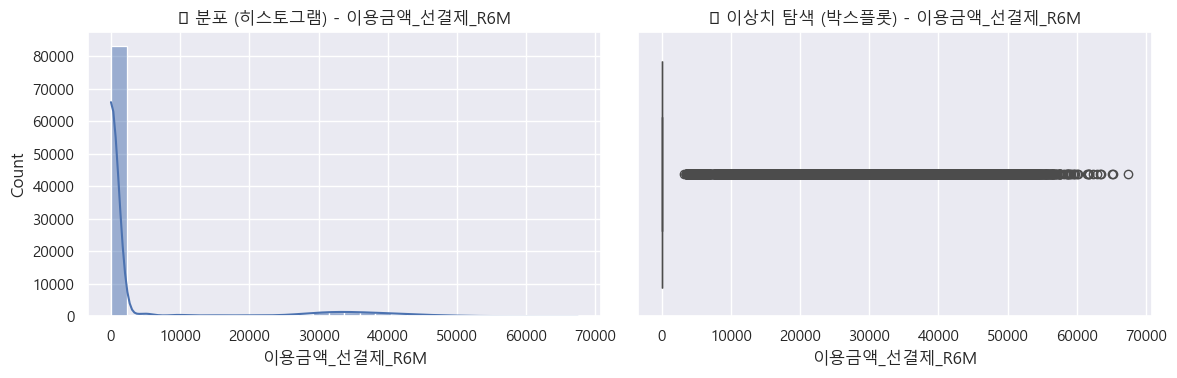

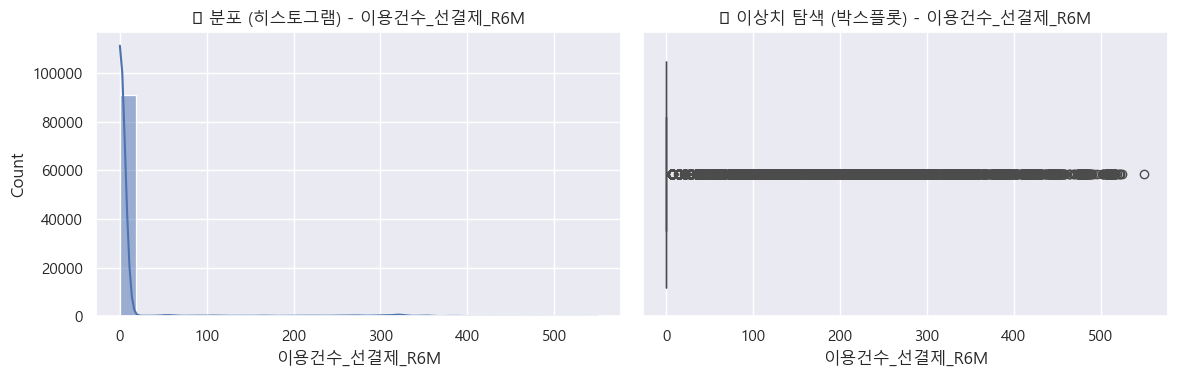

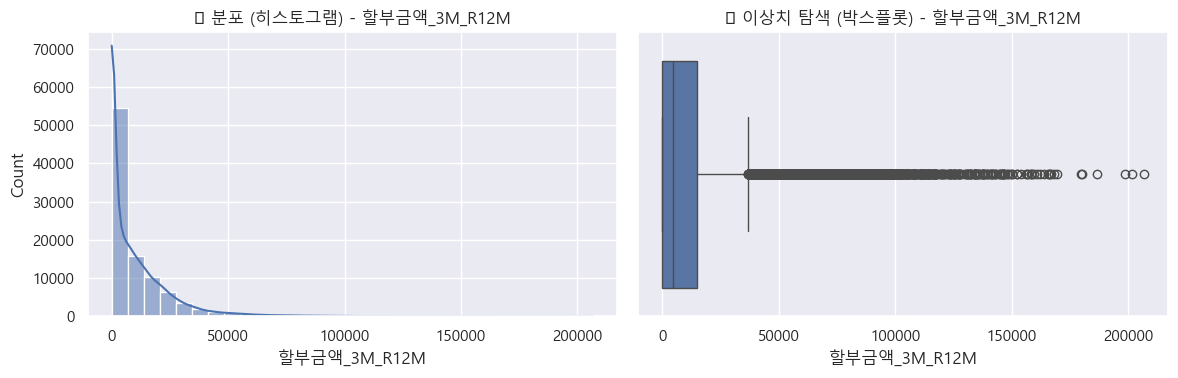

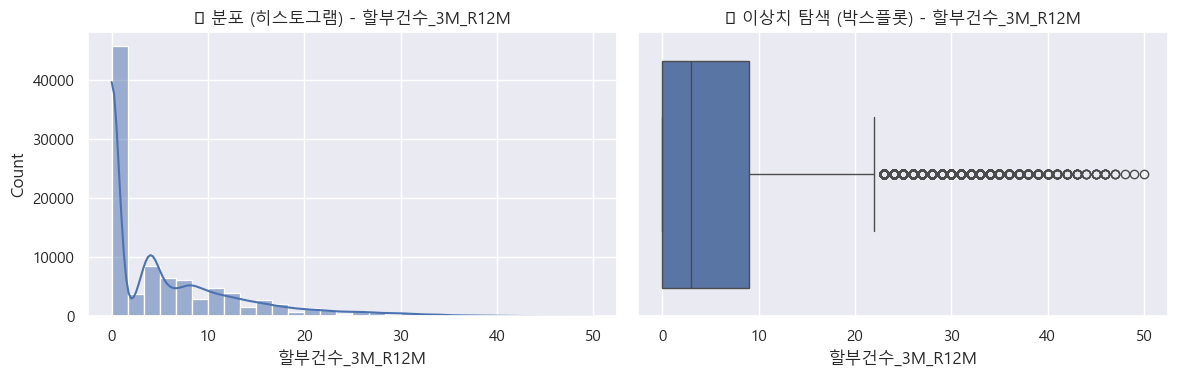

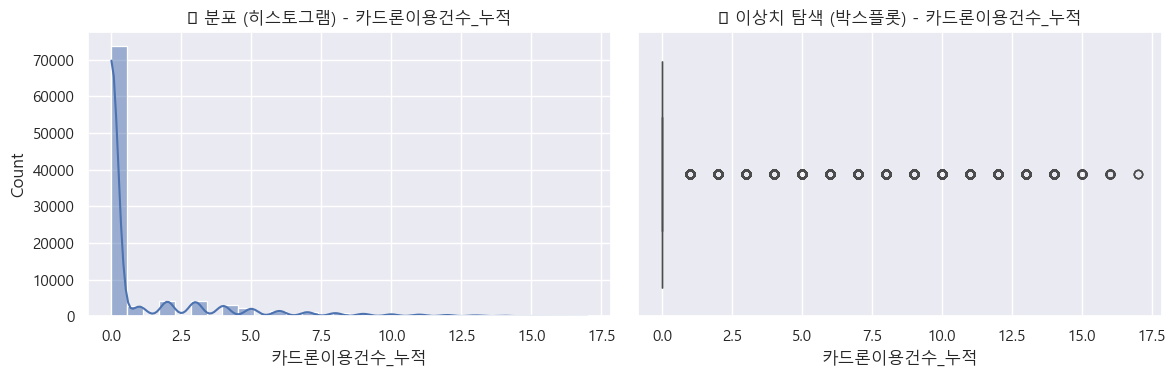

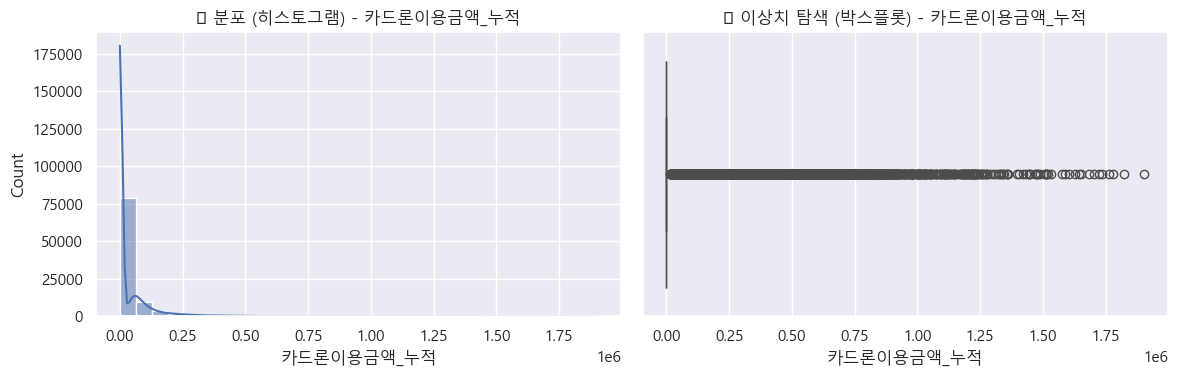

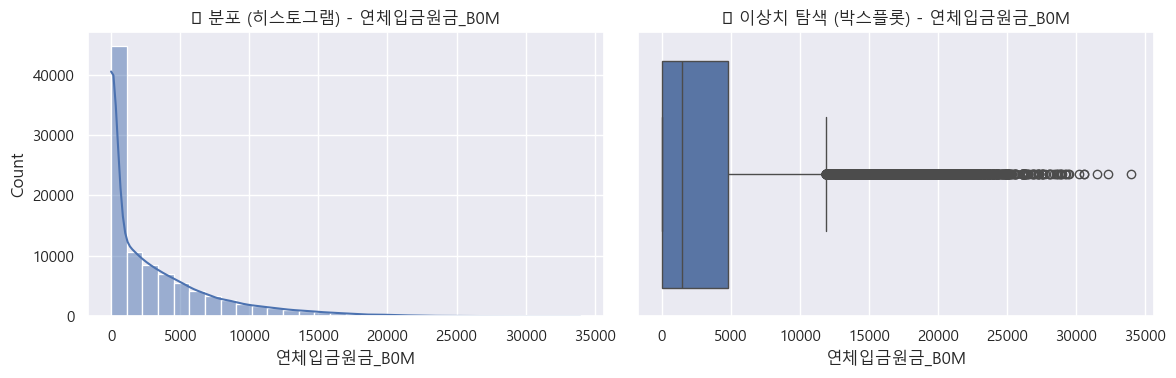

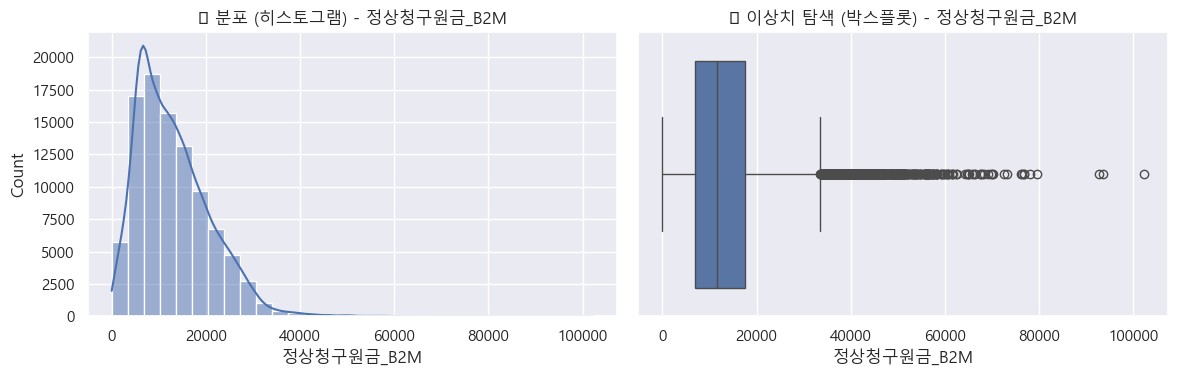

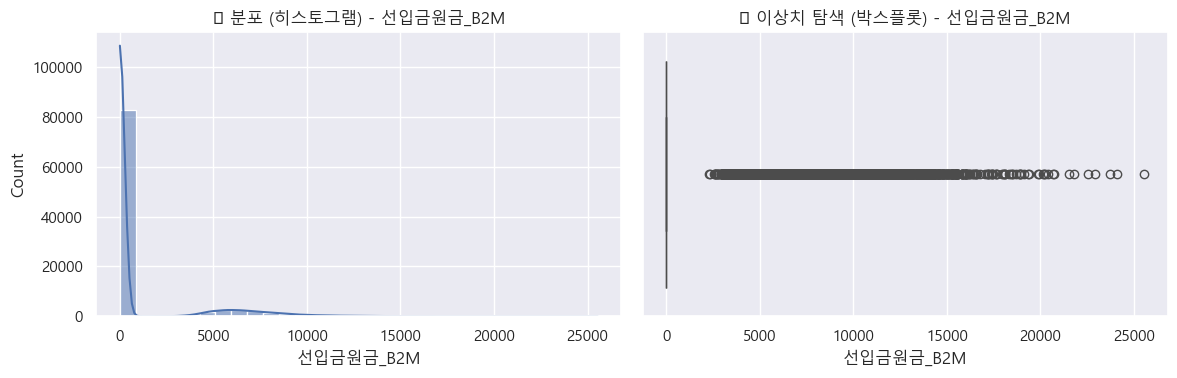

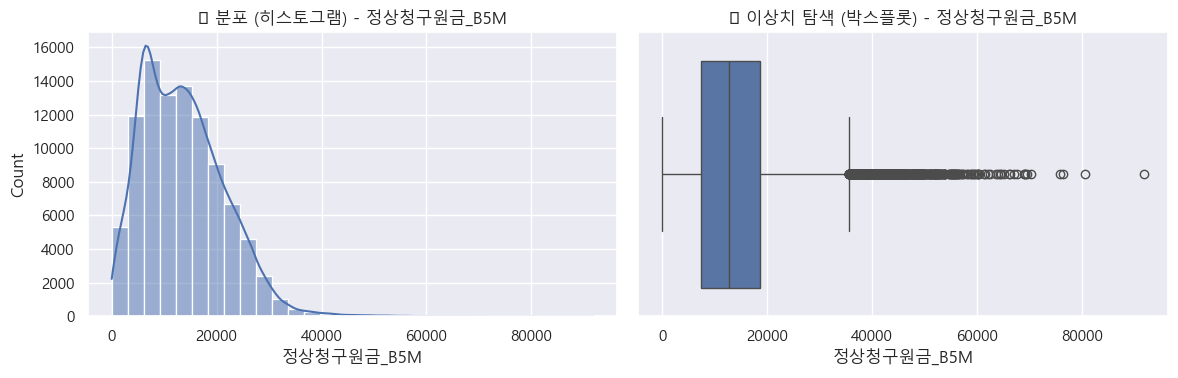

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # 히스토그램
    sns.histplot(vip_df[col], bins=30, ax=axes[0], kde=True)
    axes[0].set_title(f"🔹 분포 (히스토그램) - {col}")
    
    # 박스플롯
    sns.boxplot(x=vip_df[col], ax=axes[1])
    axes[1].set_title(f"🔸 이상치 탐색 (박스플롯) - {col}")
    
    plt.tight_layout()
    plt.show()

# 새롭게 파생 변수로 만들어줄 변수들
- 0회, 1회 이상 이렇게 분류해서 새로운 파생 변수를 제작해야 되는 컬럼 목록
1. 이용건수_선결제_R6M
2. 할부건수_3M_R12M
3. 카드론이용건수_누적

In [152]:
# 0회 / 1회 이상으로 파생 변수 생성
vip_df['선결제_이용여부'] = (vip_df['이용건수_선결제_R6M'] > 0).astype(int)
vip_df['단기할부_이용여부'] = (vip_df['할부건수_3M_R12M'] > 0).astype(int)
vip_df['카드론_이용여부'] = (vip_df['카드론이용건수_누적'] > 0).astype(int)

# 결과 확인 (선택)
print(vip_df[['선결제_이용여부', '단기할부_이용여부', '카드론_이용여부']].head())

    선결제_이용여부  단기할부_이용여부  카드론_이용여부
0          0          0         0
2          0          0         1
3          0          1         0
8          0          0         0
12         0          0         0


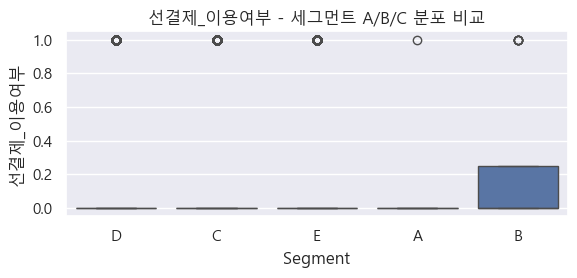

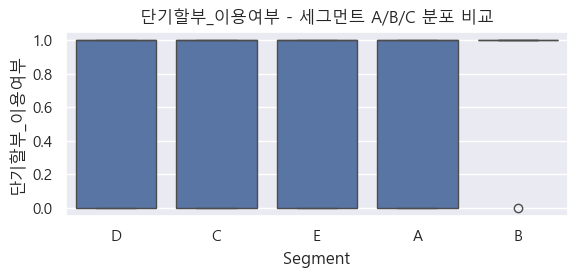

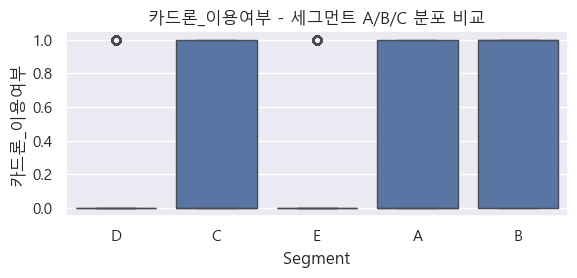

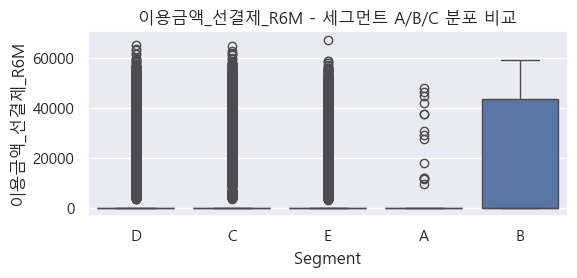

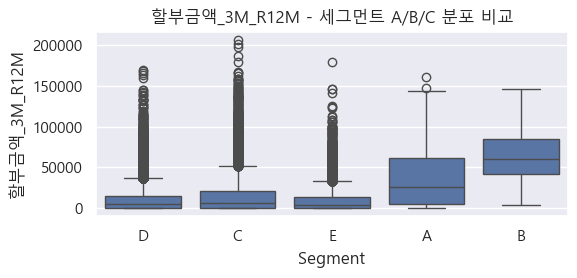

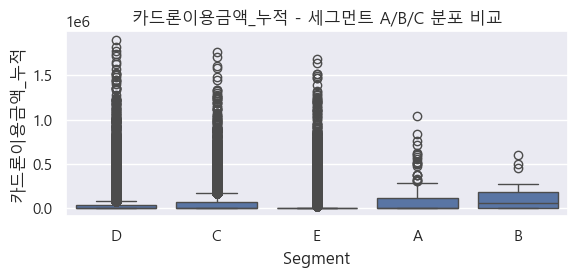

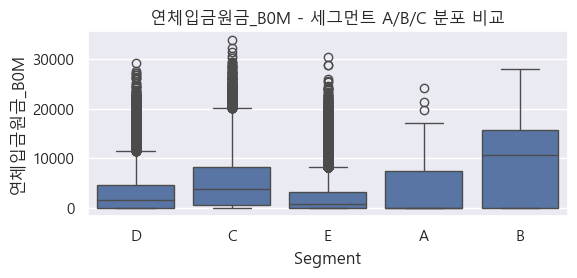

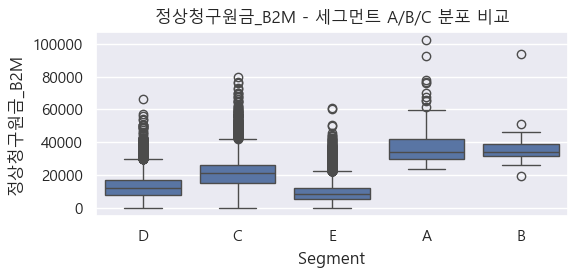

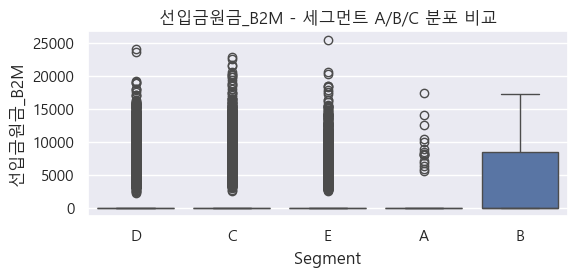

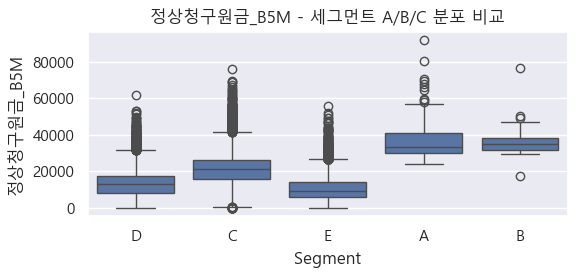

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화할 변수 목록 (Segment별 비교)
columns_to_check = ['선결제_이용여부', '단기할부_이용여부', '카드론_이용여부', '이용금액_선결제_R6M',
                '할부금액_3M_R12M', '카드론이용금액_누적', '연체입금원금_B0M', '정상청구원금_B2M', '선입금원금_B2M',
                    '정상청구원금_B5M'
                   ]

for col in columns_to_check:
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=vip_df, x='Segment', y=col)
    plt.title(f"{col} - 세그먼트 A/B/C 분포 비교")
    plt.xlabel("Segment")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

## 📊 세그먼트별 주요 변수 비교 분석 (A/B/C/D/E)

### 1. 선결제_이용여부
- B세그먼트에서만 선결제 사용 비율이 높음 (약 20%)
- 나머지 세그먼트(D, C, E, A)는 거의 사용하지 않음 (0에 수렴)
- **해석:** 선결제를 활용하는 고객은 특정 세그먼트(B)에 몰려 있음 → 재정 관리 의도 가능성

### 2. 단기할부_이용여부
- 전 세그먼트에서 대부분 단기할부 사용 경험 있음 (1에 수렴)
- **해석:** 단기할부는 전반적으로 널리 활용되고 있어, 구분 지표로는 낮음

### 3. 카드론_이용여부
- C, A, B 세그먼트는 카드론 이용 비율이 매우 높음 (1에 가까움)
- D, E 세그먼트는 거의 없음
- **해석:** **고위험 신용성향**을 가진 고객군이 C, A, B에 몰려 있음

### 4. 이용금액_선결제_R6M
- B 세그먼트가 압도적으로 높은 선결제 이용금액을 기록함
- 나머지 세그먼트는 대부분 0에 가까움
- **해석:** B는 선결제를 크게 활용하는 고액 사용자군일 수 있음

### 5. 할부금액_3M_R12M
- B > A > E 순으로 평균 할부금액이 높음
- D, C는 비교적 낮은 편
- **해석:** B세그먼트는 고소비 + 할부 활용도가 높은 적극 소비층

### 6. 카드론이용금액_누적
- B, A 세그먼트가 평균적으로 높고, 극단값(outlier)도 많이 포함
- **해석:** 카드론 누적금액 기준으로도 신용 위험도 클러스터 구분 가능

### 7. 연체입금원금_B0M
- B세그먼트의 연체 금액이 가장 높음, 그 외는 A > D > C/E 순
- **해석:** B는 연체 이력도 높은 고위험군 가능성 있음

### 8. 정상청구원금_B2M
- B > A 순으로 청구금액이 높음
- E, C, D는 낮음
- **해석:** 청구금액으로도 B와 A의 고소비 성향이 뚜렷함

### 9. 선입금원금_B2M
- B세그먼트가 압도적으로 높음
- **해석:** 선입금도 많다는 점에서, 자금 운용 적극적인 고객군일 수 있음

### 10. 정상청구원금_B5M
- 전반적으로 B > A > E > C > D 순
- **해석:** 장기적인 소비금액으로도 B세그먼트가 두드러짐

---

## 🧠 종합 해석 제안

- **B 세그먼트:** 선결제·카드론·할부·연체까지 모두 많은 **고위험 고소비층**
- **A 세그먼트:** 카드론과 연체 이력은 있으나 선결제는 낮음 → **위험 중간 소비층**
- **C 세그먼트:** 카드론 이용은 있음, 연체는 적음 → **신용사용 중심 고객군**
- **D/E 세그먼트:** 대부분 위험 낮고, 소비 성향도 낮음 → **저위험 저소비층**


## 당월 기준으로 보고 있으니까, 당월 기준 다른 컬럼들도 넣어서 살펴보자!

#### 주력 상품 파악
- 이용금액_일시불_B0M
- 이용금액_할부_B0M
- 이용금액_CA_B0M
- 이용금액_체크_B0M
- 이용금액_카드론_B0M

In [168]:
# VIP 고객만 추출
vip_df = rfm_with_segment[(rfm_with_segment['Cluster'] == 0)]

In [170]:
# 사용할 컬럼들 목록
vip_columns_add = [
    '이용금액_일시불_B0M', '이용금액_할부_B0M',
    '이용금액_CA_B0M', '이용금액_체크_B0M',
    '이용금액_카드론_B0M'
]

# 원본 df에서 해당 컬럼들만 추출
vip_df[vip_columns_add] = df3_12mon.loc[vip_df.index, vip_columns_add]

# 추가 되었는지 확인
vip_df.head()

,ID,이용후경과월_신용,이용건수합계_B0M_정제,결제금액합계_B0M_정제,R_score,F_score,M_score,Cluster,Segment,이용금액_일시불_B0M,이용금액_할부_B0M,이용금액_CA_B0M,이용금액_체크_B0M,이용금액_카드론_B0M
0,TRAIN_000000,0,7,13370,5,5,4,0,D,1079,0,12291,0,0
2,TRAIN_000002,0,20,25707,5,5,5,0,C,8373,0,17334,0,0
3,TRAIN_000003,0,12,16996,5,5,5,0,D,780,4150,12066,0,0
8,TRAIN_000008,0,78,25120,5,5,5,0,C,22941,0,0,2179,0
12,TRAIN_000012,0,61,15691,5,5,5,0,D,15691,0,0,0,0


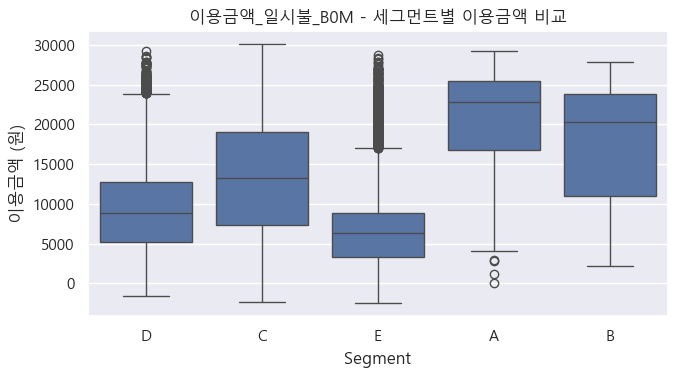

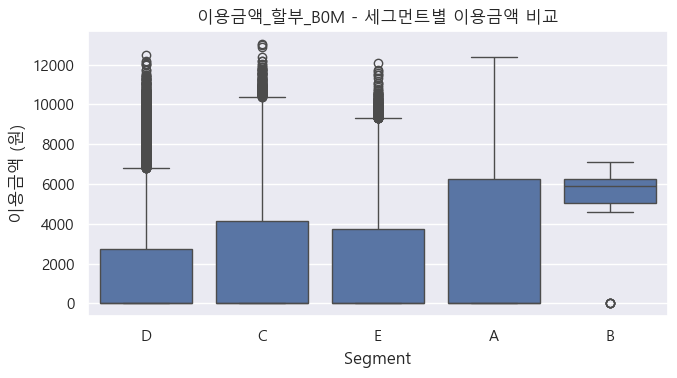

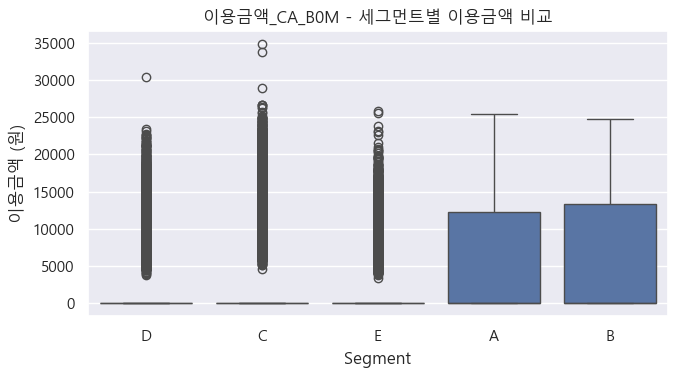

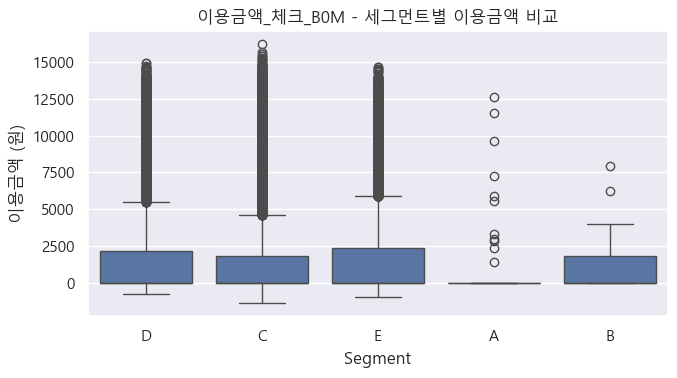

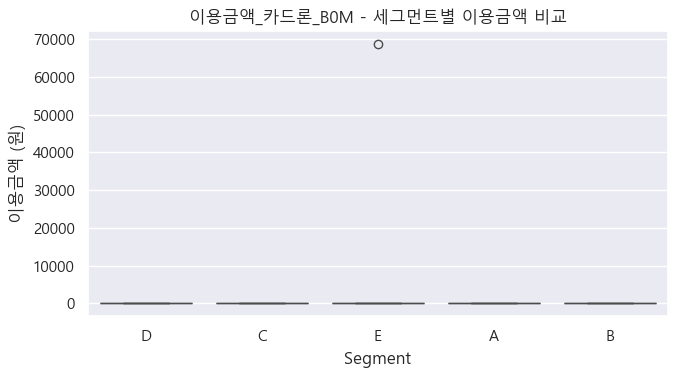

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns

# 주력 상품 이용금액 컬럼 리스트
product_cols = [
    '이용금액_일시불_B0M',
    '이용금액_할부_B0M',
    '이용금액_CA_B0M',
    '이용금액_체크_B0M',
    '이용금액_카드론_B0M'
]

# 시각화
for col in product_cols:
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=vip_df, x='Segment', y=col)
    plt.title(f"{col} - 세그먼트별 이용금액 비교")
    plt.ylabel("이용금액 (원)")
    plt.xlabel("Segment")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

## 세그먼트별 주력상품 이용금액 비교 분석

### 1. 이용금액_일시불_B0M
- Segment A, B가 다른 그룹에 비해 일시불 이용금액이 전반적으로 높음.
- 특히 A는 중앙값 기준으로도 가장 높은 수준이며, 일시불이 주력 소비 수단일 가능성이 높음.
- Segment E, D는 평균/중앙값 모두 낮아 상대적으로 비활성 또는 저소득 소비군으로 추정됨.

### 2. 이용금액_할부_B0M
- Segment A, B에서 할부 이용금액이 높음. 특히 A는 이상치가 많이 포함된 것으로 보이며, 분산이 큼.
- Segment D, C는 할부 사용량이 낮고, 비교적 일시불보다도 사용 비중이 낮음.

### 3. 이용금액_CA_B0M
- A, B 그룹이 CA(현금서비스)를 주력으로 쓰는 비율이 높은 편이며, 이는 단기 유동성 부족 가능성을 암시.
- D, C, E 그룹은 거의 사용하지 않음. 현금서비스는 위험지표가 될 수 있음.

### 4. 이용금액_체크_B0M
- 체크카드는 모든 세그먼트에서 대체로 낮은 수준이며, 큰 차이는 나타나지 않음.
- Segment C, D는 소폭 더 높은 경향을 보임.

### 5. 이용금액_카드론_B0M
- 대부분의 세그먼트에서 0에 수렴.
- 극소수의 이상값만 존재하며, 현재 당월 기준으로는 주력 상품으로 보기 어려움.

## 💡 결론
- Segment A, B는 일시불/할부/현금서비스 사용량이 높아 **고액 사용/신용의존형 소비자**로 분류 가능.
- Segment C, D는 보수적 소비 패턴으로, **저소득 or 소비 비활성군**으로 해석 가능.


In [175]:
# 비중으로 결과 나타내보기
# 사용할 컬럼 리스트
product_cols = [
    '이용금액_일시불_B0M',
    '이용금액_할부_B0M',
    '이용금액_CA_B0M',
    '이용금액_체크_B0M',
    '이용금액_카드론_B0M'
]

# 전체 이용금액 합계 계산
vip_df['총이용금액_B0M'] = vip_df[product_cols].sum(axis=1)

# 각 상품 비중 계산 (0으로 나누기 방지)
for col in product_cols:
    new_col = f"{col}_비중"
    vip_df[new_col] = vip_df[col] / (vip_df['총이용금액_B0M'] + 1e-6)

# 결과 확인 (일부만)
vip_df[[col for col in vip_df.columns if '비중' in col]].describe()

,이용금액_일시불_B0M_비중,이용금액_할부_B0M_비중,이용금액_CA_B0M_비중,이용금액_체크_B0M_비중,이용금액_카드론_B0M_비중
count,96198.00,96198.00,96198.00,96198.00,96198.00
mean,0.67,0.11,0.10,0.12,0.00
std,0.34,0.19,0.26,0.23,0.00
min,-0.38,0.00,0.00,-0.14,0.00
25%,0.38,0.00,0.00,0.00,0.00
50%,0.72,0.00,0.00,0.00,0.00
75%,1.00,0.20,0.00,0.15,0.00
max,1.11,1.16,1.38,1.27,0.91


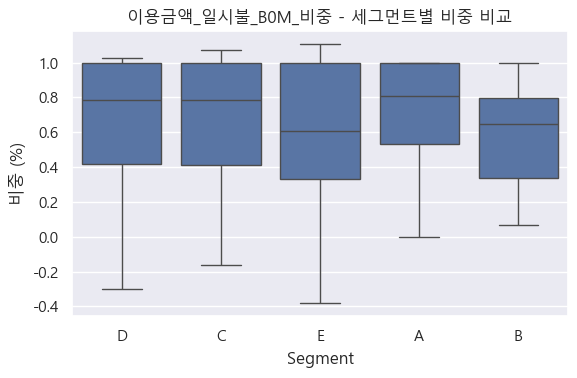

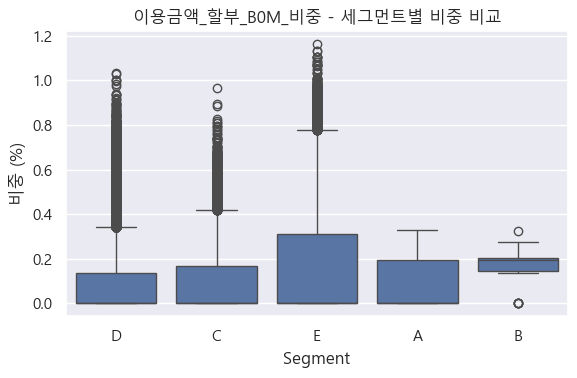

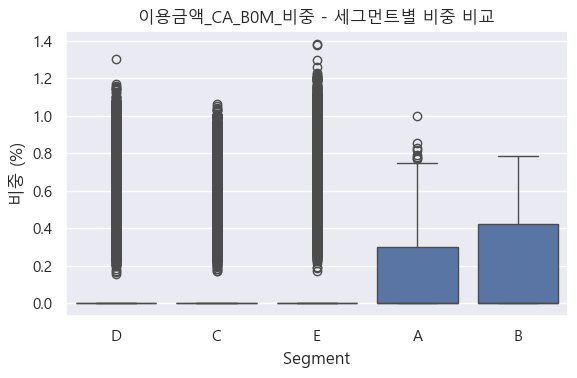

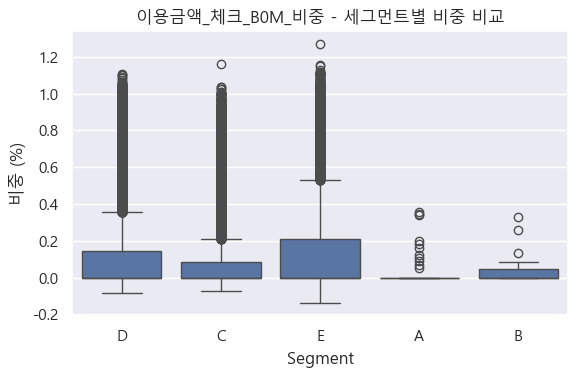

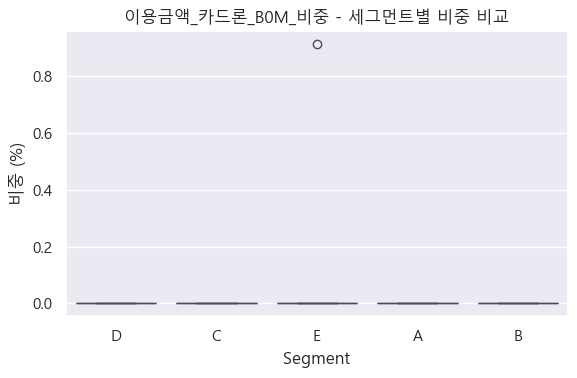

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns

# 비중 컬럼 리스트
ratio_cols = [
    '이용금액_일시불_B0M_비중',
    '이용금액_할부_B0M_비중',
    '이용금액_CA_B0M_비중',
    '이용금액_체크_B0M_비중',
    '이용금액_카드론_B0M_비중'
]

# 시각화
for col in ratio_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=vip_df, x='Segment', y=col)
    plt.title(f"{col} - 세그먼트별 비중 비교")
    plt.ylabel("비중 (%)")
    plt.xlabel("Segment")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()